In [ ]:
# Heart Disease Prediction - Advanced ML Analysis
# Import necessary libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.utils import resample
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import lightgbm as lgb
import pickle
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Advanced ML libraries imported successfully!")
print("Available techniques: SMOTE, ADASYN, XGBoost, LightGBM, Feature Selection, Cross-Validation")

In [ ]:
# Load the dataset
print("Loading Heart Disease Dataset...")
dataset = pd.read_csv('https://raw.githubusercontent.com/kushal140/datasets/main/heart_2020_cleaned.csv')

# Display basic information about the dataset
print(f"Dataset shape: {dataset.shape}")
print(f"Columns: {list(dataset.columns)}")
print("\nFirst few rows:")
dataset.head()

In [ ]:
# Comprehensive Data Exploration
print("=== DATASET OVERVIEW ===")
print(f"Dataset shape: {dataset.shape}")
print(f"Memory usage: {dataset.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n=== DATA TYPES ===")
print(dataset.dtypes)

print("\n=== MISSING VALUES ===")
missing_values = dataset.isnull().sum()
print(missing_values[missing_values > 0])

print("\n=== TARGET VARIABLE DISTRIBUTION ===")
print(dataset['HeartDisease'].value_counts())
print(f"Percentage of Heart Disease cases: {dataset['HeartDisease'].value_counts()[1] / len(dataset) * 100:.2f}%")

print("\n=== STATISTICAL SUMMARY ===")
dataset.describe()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
319790,Yes,27.41,Yes,No,No,7.0,0.0,Yes,Male,60-64,Hispanic,Yes,No,Fair,6.0,Yes,No,No
319791,No,29.84,Yes,No,No,0.0,0.0,No,Male,35-39,Hispanic,No,Yes,Very good,5.0,Yes,No,No
319792,No,24.24,No,No,No,0.0,0.0,No,Female,45-49,Hispanic,No,Yes,Good,6.0,No,No,No
319793,No,32.81,No,No,No,0.0,0.0,No,Female,25-29,Hispanic,No,No,Good,12.0,No,No,No
319794,No,46.56,No,No,No,0.0,0.0,No,Female,80 or older,Hispanic,No,Yes,Good,8.0,No,No,No


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
319790,Yes,27.41,Yes,No,No,7.0,0.0,Yes,Male,60-64,Hispanic,Yes,No,Fair,6.0,Yes,No,No
319791,No,29.84,Yes,No,No,0.0,0.0,No,Male,35-39,Hispanic,No,Yes,Very good,5.0,Yes,No,No
319792,No,24.24,No,No,No,0.0,0.0,No,Female,45-49,Hispanic,No,Yes,Good,6.0,No,No,No
319793,No,32.81,No,No,No,0.0,0.0,No,Female,25-29,Hispanic,No,No,Good,12.0,No,No,No
319794,No,46.56,No,No,No,0.0,0.0,No,Female,80 or older,Hispanic,No,Yes,Good,8.0,No,No,No


In [ ]:
# Enhanced Exploratory Data Analysis (EDA)
# 1. Target Variable Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Heart Disease Distribution
heart_disease_counts = dataset['HeartDisease'].value_counts()
axes[0,0].pie(heart_disease_counts.values, labels=['No Heart Disease', 'Heart Disease'], 
              autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
axes[0,0].set_title('Heart Disease Distribution', fontsize=14, fontweight='bold')

# BMI Distribution by Heart Disease
sns.histplot(data=dataset, x='BMI', hue='HeartDisease', kde=True, ax=axes[0,1])
axes[0,1].set_title('BMI Distribution by Heart Disease Status')
axes[0,1].set_xlabel('BMI')

# Age Category vs Heart Disease
age_heart = pd.crosstab(dataset['AgeCategory'], dataset['HeartDisease'])
age_heart_pct = age_heart.div(age_heart.sum(axis=1), axis=0)
age_heart_pct.plot(kind='bar', ax=axes[1,0], stacked=True)
axes[1,0].set_title('Heart Disease Rate by Age Category')
axes[1,0].set_xlabel('Age Category')
axes[1,0].set_ylabel('Proportion')
axes[1,0].legend(['No Heart Disease', 'Heart Disease'])
axes[1,0].tick_params(axis='x', rotation=45)

# Physical Health vs Heart Disease
sns.boxplot(data=dataset, x='HeartDisease', y='PhysicalHealth', ax=axes[1,1])
axes[1,1].set_title('Physical Health Score by Heart Disease Status')
axes[1,1].set_xlabel('Heart Disease')
axes[1,1].set_ylabel('Physical Health Score')

plt.tight_layout()
plt.show()

# 2. Correlation Analysis
print("=== CORRELATION ANALYSIS ===")
# Create correlation matrix for numerical variables
numerical_cols = dataset.select_dtypes(include=[np.number]).columns
correlation_matrix = dataset[numerical_cols].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numerical Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Advanced Feature Analysis
print("=== FEATURE IMPORTANCE ANALYSIS ===")

# Analyze categorical features
categorical_features = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 
                       'Diabetic', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer']

fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.ravel()

for i, feature in enumerate(categorical_features):
    if i < len(axes):
        # Create crosstab
        crosstab = pd.crosstab(dataset[feature], dataset['HeartDisease'], normalize='index')
        crosstab.plot(kind='bar', ax=axes[i], stacked=True)
        axes[i].set_title(f'{feature} vs Heart Disease')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Proportion')
        axes[i].legend(['No Heart Disease', 'Heart Disease'])
        axes[i].tick_params(axis='x', rotation=45)

# Hide unused subplots
for i in range(len(categorical_features), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# Risk Factor Analysis
print("\n=== RISK FACTOR ANALYSIS ===")
risk_factors = ['Smoking', 'AlcoholDrinking', 'Stroke', 'Diabetic', 'Asthma', 'KidneyDisease', 'SkinCancer']
for factor in risk_factors:
    if factor in dataset.columns:
        risk_rate = dataset.groupby(factor)['HeartDisease'].mean()
        print(f"{factor}:")
        for value, rate in risk_rate.items():
            print(f"  {value}: {rate:.3f} ({rate*100:.1f}%)")
        print()

In [ ]:
#plt.figure(figsize=(10,5)) 
#sns.set(font_scale = 2, style = 'darkgrid')
#bar_plot = sns.countplot(data=dataset, x=dataset['HeartDisease'],palette='mako',alpha = 0.5 )                                             
#bar_plot.set_title("HeartDisease", fontweight="bold") 
#bar_plot.set_ylabel("Frecuency")
#bar_plot.set_xlabel('HeartDisease') 
#plt.show()

In [ ]:
#dataset.BMI.describe()

In [ ]:
#dataset.BMI.quantile(q = 0.05)

In [ ]:
#dataset.BMI.quantile(q = 0.95)

In [ ]:
#plt.figure(figsize=(20,26))
#sns.set(font_scale = 2, style = 'darkgrid')
#ax= [None for _ in range(2)]

#ax[0] = plt.subplot2grid((3,4), (0,0), colspan = 2)
#ax[1] = plt.subplot2grid((3,4), (1,0), colspan = 2)


#sns.histplot(data= dataset, x = "BMI",palette='mako',alpha = 0.5 ,binwidth = 3,kde = True, ax=ax[0])
#sns.histplot(data= dataset, x = "BMI",palette='mako',alpha = 0.5 ,binwidth = 3,kde = True, ax=ax[1],hue = 'HeartDisease')
#ax[0].set_title('BMI')
#ax[1].set_title('BMI and HeartDisease')
#plt.show()

In [ ]:
#plt.figure(figsize=(20,26))
#sns.set(font_scale = 2, style = 'darkgrid')
#ax= [None for _ in range(2)]

#ax[0] = plt.subplot2grid((3,4), (0,0), colspan = 2)
#ax[1] = plt.subplot2grid((3,4), (1,0), colspan = 2)


#sns.countplot(data=dataset, x='Smoking',palette='mako',alpha = 0.5, ax=ax[0])
#sns.countplot(data=dataset, x='Smoking',palette='mako', hue = 'HeartDisease', alpha = 0.5, ax=ax[1])

#ax[0].set_title('Smoking')
#ax[1].set_title('Smoking and HeartDisease')
#plt.show()

In [ ]:
#dataset.AlcoholDrinking.value_counts()

In [ ]:
#plt.figure(figsize=(20,26))
#sns.set(font_scale = 2, style = 'darkgrid')
#ax= [None for _ in range(2)]

#ax[0] = plt.subplot2grid((3,4), (0,0), colspan = 2)
#ax[1] = plt.subplot2grid((3,4), (1,0), colspan = 2)


#sns.countplot(data=dataset, x='AlcoholDrinking',palette='mako',alpha = 0.5, ax=ax[0])
#sns.countplot(data=dataset, x='AlcoholDrinking',palette='mako', hue = 'HeartDisease', alpha = 0.5, ax=ax[1])

#ax[0].set_title('AlcoholDrinking')
#ax[1].set_title('AlcoholDrinking and HeartDisease')
#plt.show()

In [ ]:
#plt.figure(figsize=(20,26))
#sns.set(font_scale = 2, style = 'darkgrid')
#ax= [None for _ in range(2)]

#ax[0] = plt.subplot2grid((3,4), (0,0), colspan = 2)
#ax[1] = plt.subplot2grid((3,4), (1,0), colspan = 2)


#sns.countplot(data=dataset, x='Stroke',palette='mako',alpha = 0.5, ax=ax[0])
#sns.countplot(data=dataset, x='Stroke',palette='mako', hue = 'HeartDisease', alpha = 0.5, ax=ax[1])

#ax[0].set_title('Stroke')
#ax[1].set_title('Stroke and HeardDisease')
#plt.show()

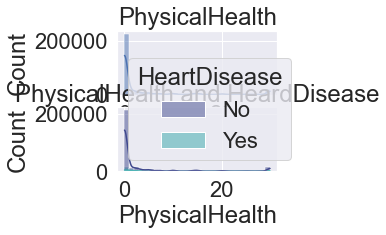

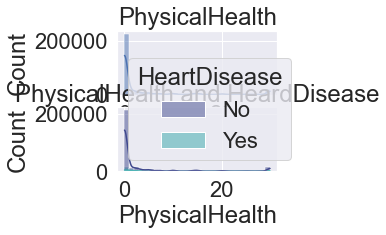

In [ ]:
#plt.figure(figsize=(20,26))
sns.set(font_scale = 2, style = 'darkgrid')
ax= [None for _ in range(2)]

ax[0] = plt.subplot2grid((3,4), (0,0), colspan = 2)
ax[1] = plt.subplot2grid((3,4), (1,0), colspan = 2)


sns.histplot(data= dataset, x = "PhysicalHealth",palette='mako',alpha = 0.5 ,binwidth = 1,kde = True, ax=ax[0])
sns.histplot(data= dataset, x = "PhysicalHealth",palette='mako',alpha = 0.5 ,binwidth = 1,kde = True, ax=ax[1],hue = 'HeartDisease')
ax[0].set_title('PhysicalHealth')
ax[1].set_title('PhysicalHealth and HeardDisease')
plt.show()

In [ ]:
dataset.MentalHealth.quantile(q = 0.90)

15.0

15.0

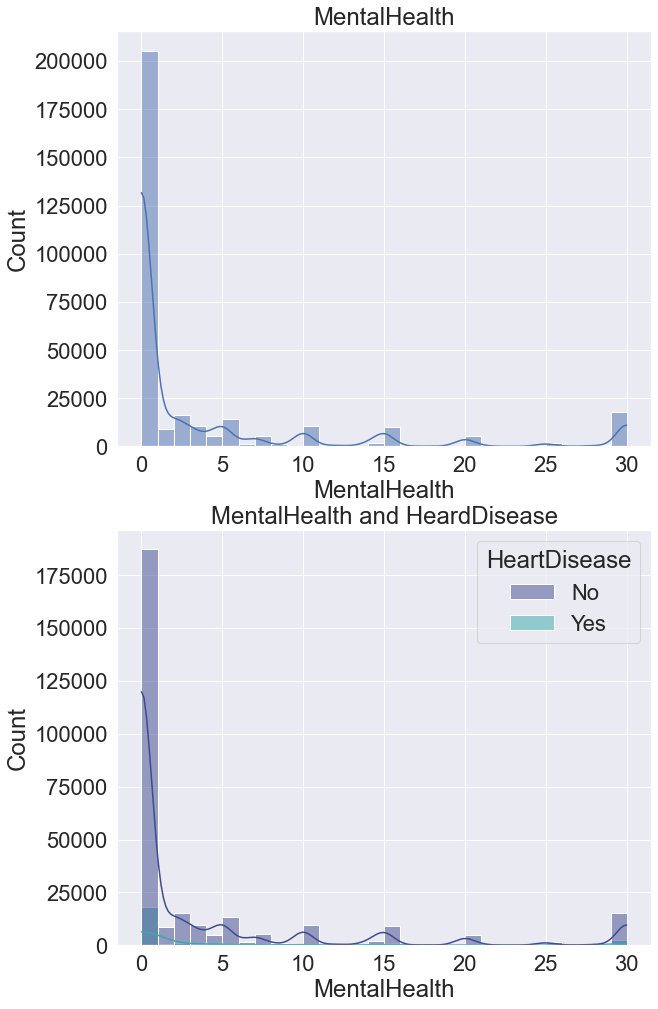

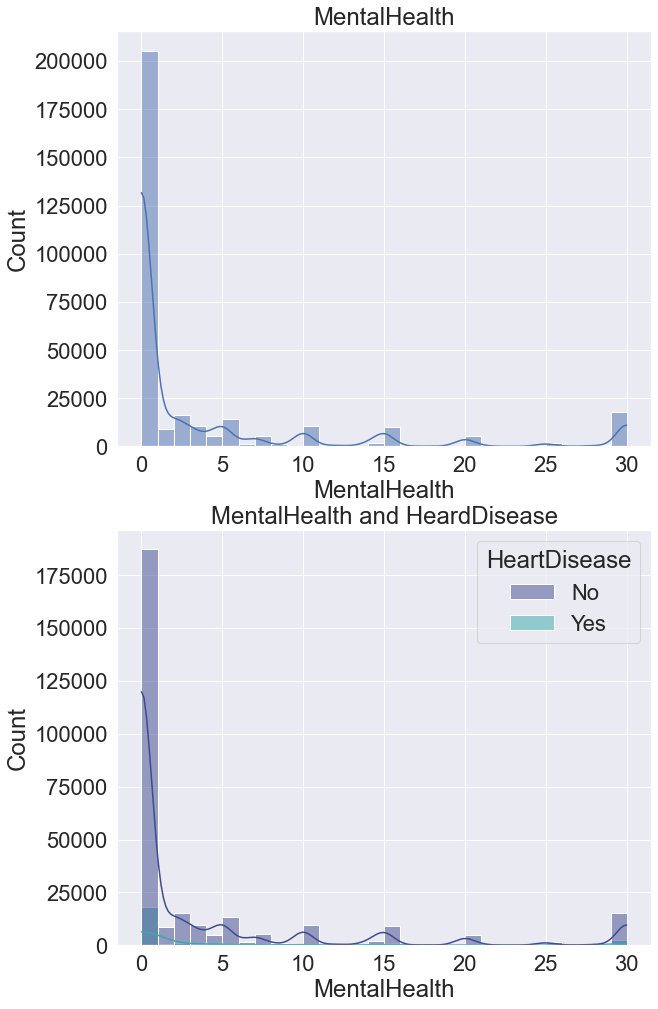

In [ ]:
plt.figure(figsize=(20,26))
sns.set(font_scale = 2, style = 'darkgrid')
ax= [None for _ in range(2)]

ax[0] = plt.subplot2grid((3,4), (0,0), colspan = 2)
ax[1] = plt.subplot2grid((3,4), (1,0), colspan = 2)


sns.histplot(data= dataset, x = "MentalHealth",palette='mako',alpha = 0.5 ,binwidth = 1,kde = True, ax=ax[0])
sns.histplot(data= dataset, x = "MentalHealth",palette='mako',alpha = 0.5 ,binwidth = 1,kde = True, ax=ax[1],hue = 'HeartDisease')
ax[0].set_title('MentalHealth')
ax[1].set_title('MentalHealth and HeardDisease')
plt.show()

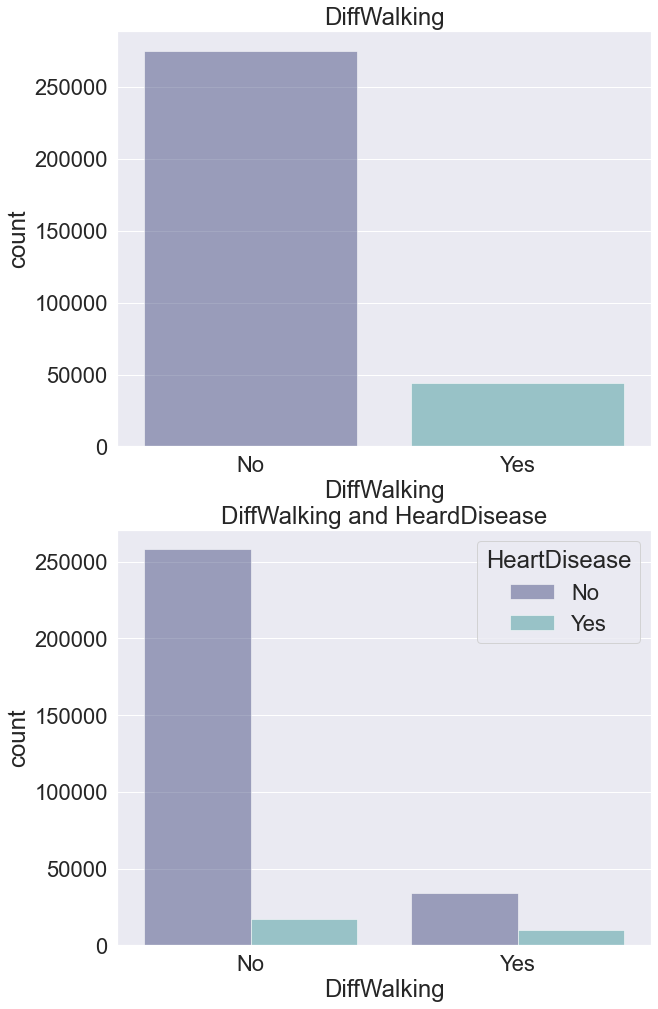

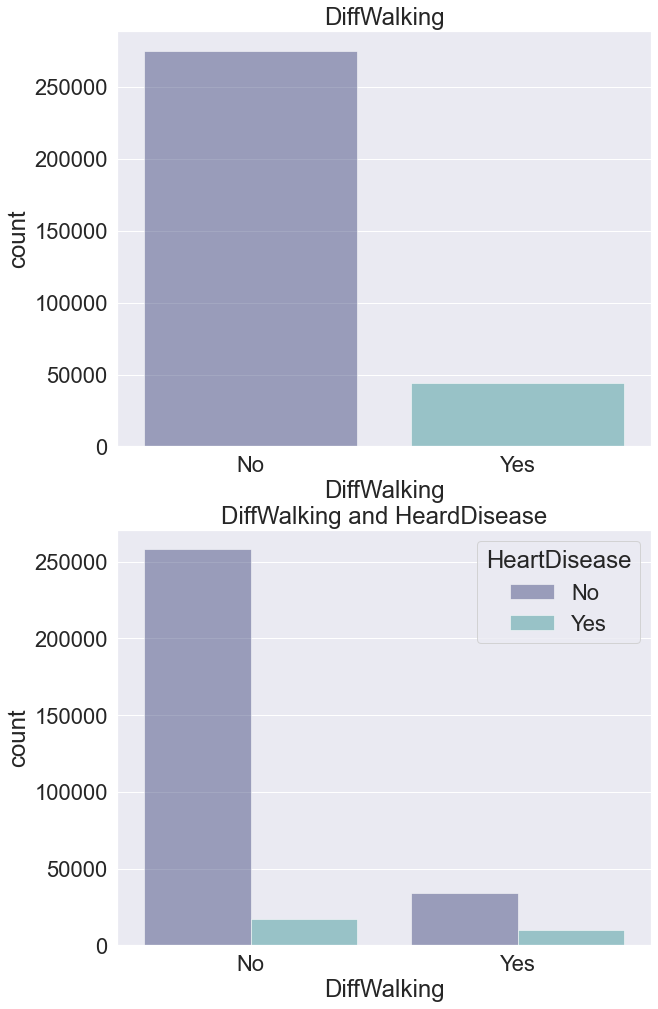

In [ ]:
plt.figure(figsize=(20,26))
sns.set(font_scale = 2, style = 'darkgrid')
ax= [None for _ in range(2)]

ax[0] = plt.subplot2grid((3,4), (0,0), colspan = 2)
ax[1] = plt.subplot2grid((3,4), (1,0), colspan = 2)


sns.countplot(data=dataset, x='DiffWalking',palette='mako',alpha = 0.5, ax=ax[0])
sns.countplot(data=dataset, x='DiffWalking',palette='mako', hue = 'HeartDisease', alpha = 0.5, ax=ax[1])

ax[0].set_title('DiffWalking')
ax[1].set_title('DiffWalking and HeardDisease')
plt.show()

In [ ]:
dataset.Sex.value_counts()

Female    167805
Male      151990
Name: Sex, dtype: int64

Female    167805
Male      151990
Name: Sex, dtype: int64

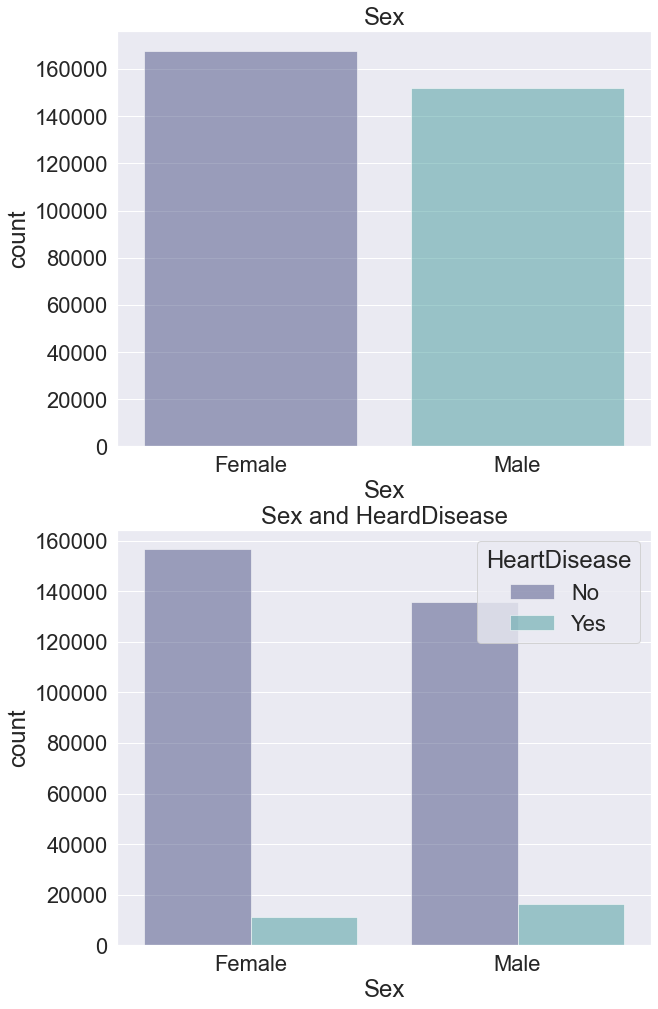

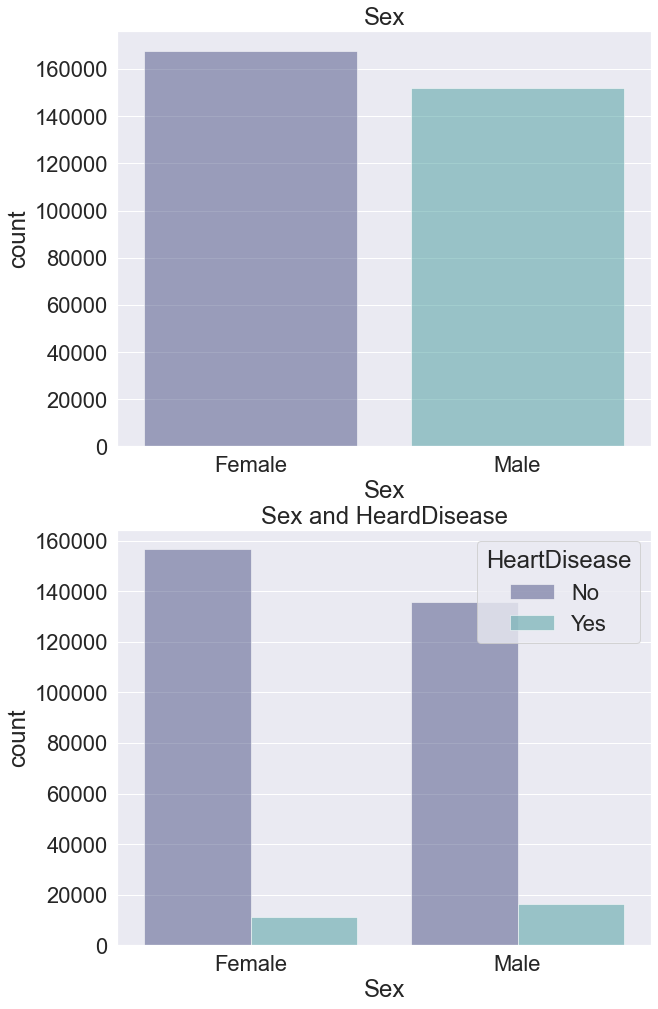

In [ ]:
plt.figure(figsize=(20,26))
sns.set(font_scale = 2, style = 'darkgrid')
ax= [None for _ in range(2)]

ax[0] = plt.subplot2grid((3,4), (0,0), colspan = 2)
ax[1] = plt.subplot2grid((3,4), (1,0), colspan = 2)


sns.countplot(data=dataset, x='Sex',palette='mako',alpha = 0.5, ax=ax[0])
sns.countplot(data=dataset, x='Sex',palette='mako', hue = 'HeartDisease', alpha = 0.5, ax=ax[1])

ax[0].set_title('Sex')
ax[1].set_title('Sex and HeardDisease')
plt.show()

In [ ]:
order = ['18-24','25-29', '30-34', '35-39','40-44', '45-49', '50-54', '55-59', '65-69', '60-64', '70-74','75-79', '80 or older']

In [ ]:
dataset.AgeCategory.value_counts()

65-69          34151
60-64          33686
70-74          31065
55-59          29757
50-54          25382
80 or older    24153
45-49          21791
75-79          21482
18-24          21064
40-44          21006
35-39          20550
30-34          18753
25-29          16955
Name: AgeCategory, dtype: int64

65-69          34151
60-64          33686
70-74          31065
55-59          29757
50-54          25382
80 or older    24153
45-49          21791
75-79          21482
18-24          21064
40-44          21006
35-39          20550
30-34          18753
25-29          16955
Name: AgeCategory, dtype: int64

In [ ]:
dataset['AgeCategory'] = pd.Categorical(dataset['AgeCategory'], order )

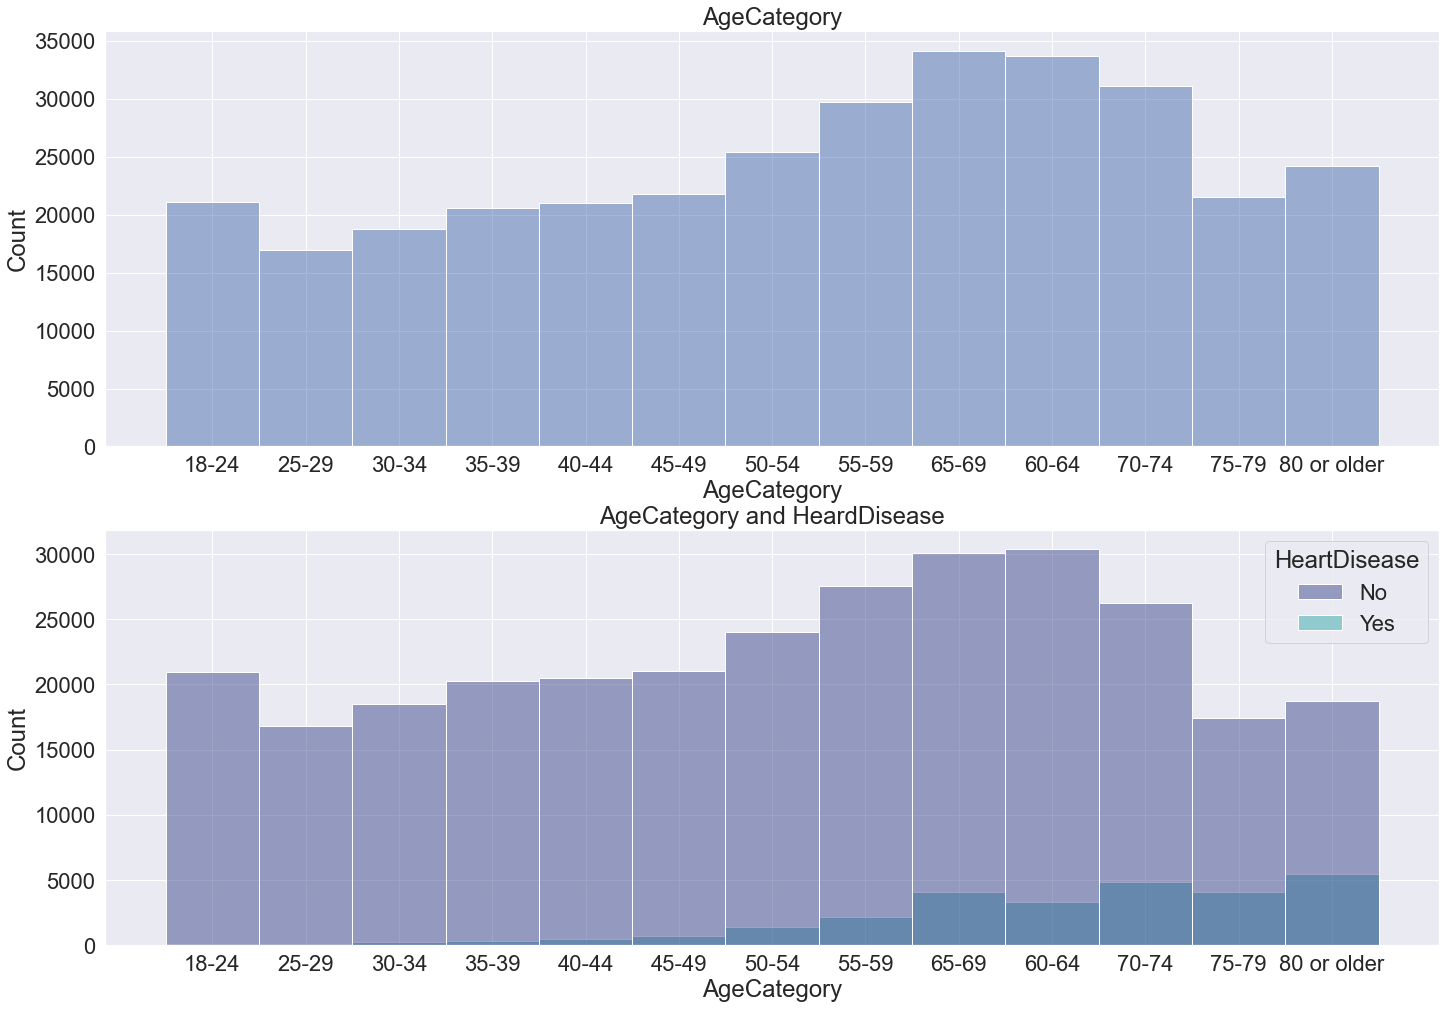

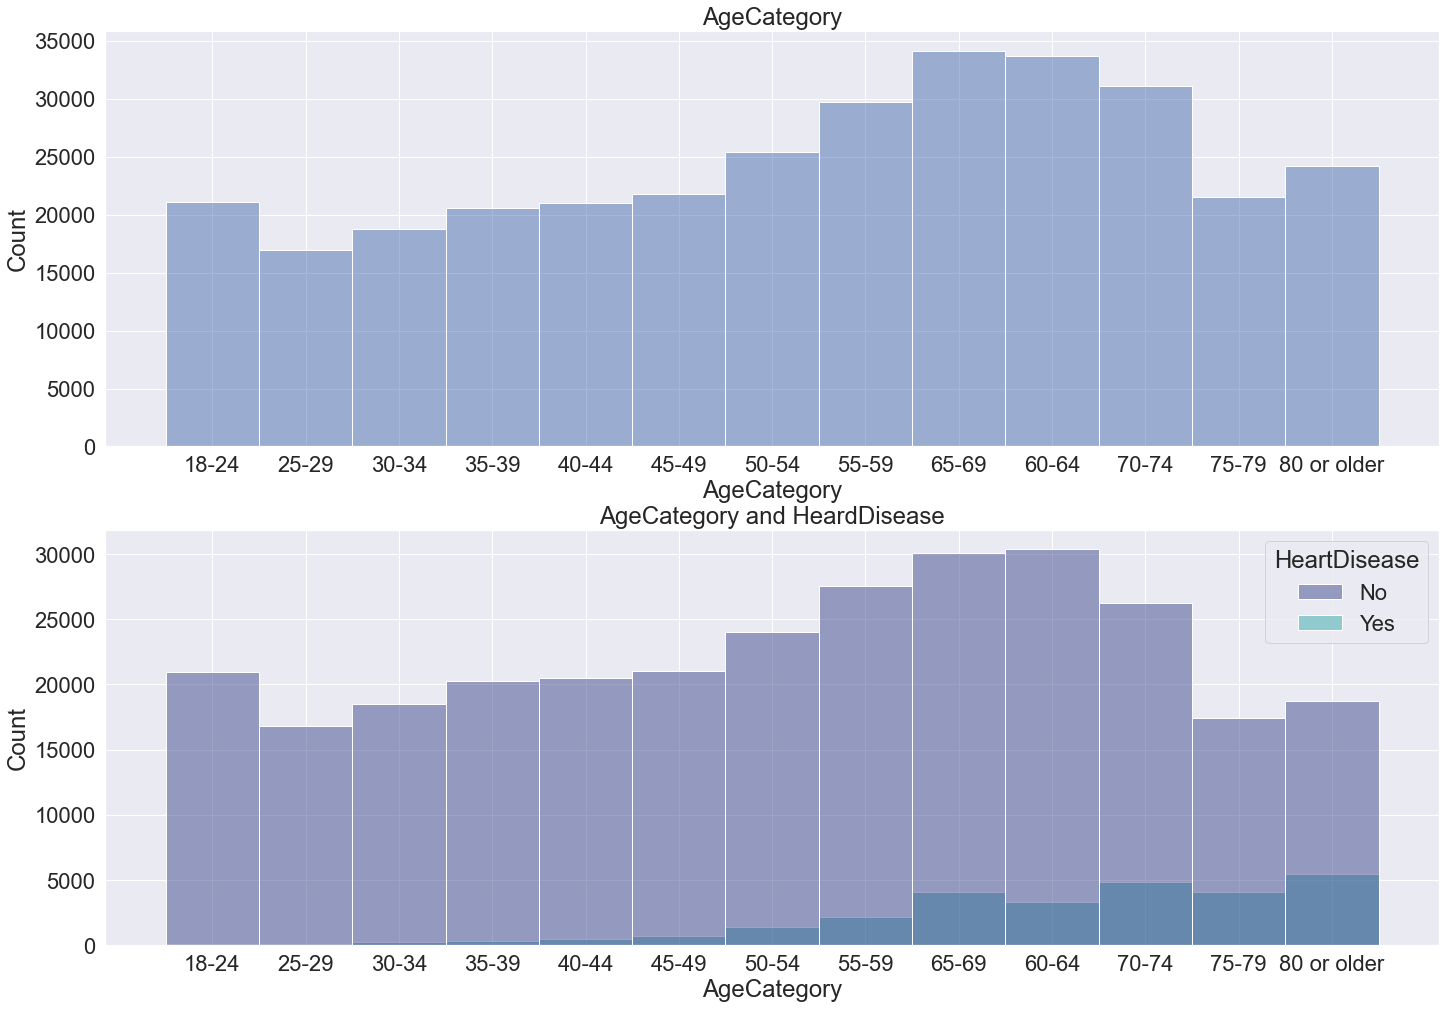

In [ ]:
plt.figure(figsize=(50,26))
sns.set(font_scale = 2, style = 'darkgrid')
ax= [None for _ in range(2)]

ax[0] = plt.subplot2grid((3,4), (0,0), colspan = 2)
ax[1] = plt.subplot2grid((3,4), (1,0), colspan = 2)


sns.histplot(data= dataset, x = "AgeCategory",palette='mako',alpha = 0.5 ,binwidth = 6, ax=ax[0])
sns.histplot(data= dataset, x = "AgeCategory",palette='mako',alpha = 0.5 ,binwidth = 6, ax=ax[1],hue = 'HeartDisease')
ax[0].set_title('AgeCategory')
ax[1].set_title('AgeCategory and HeardDisease')
plt.show()

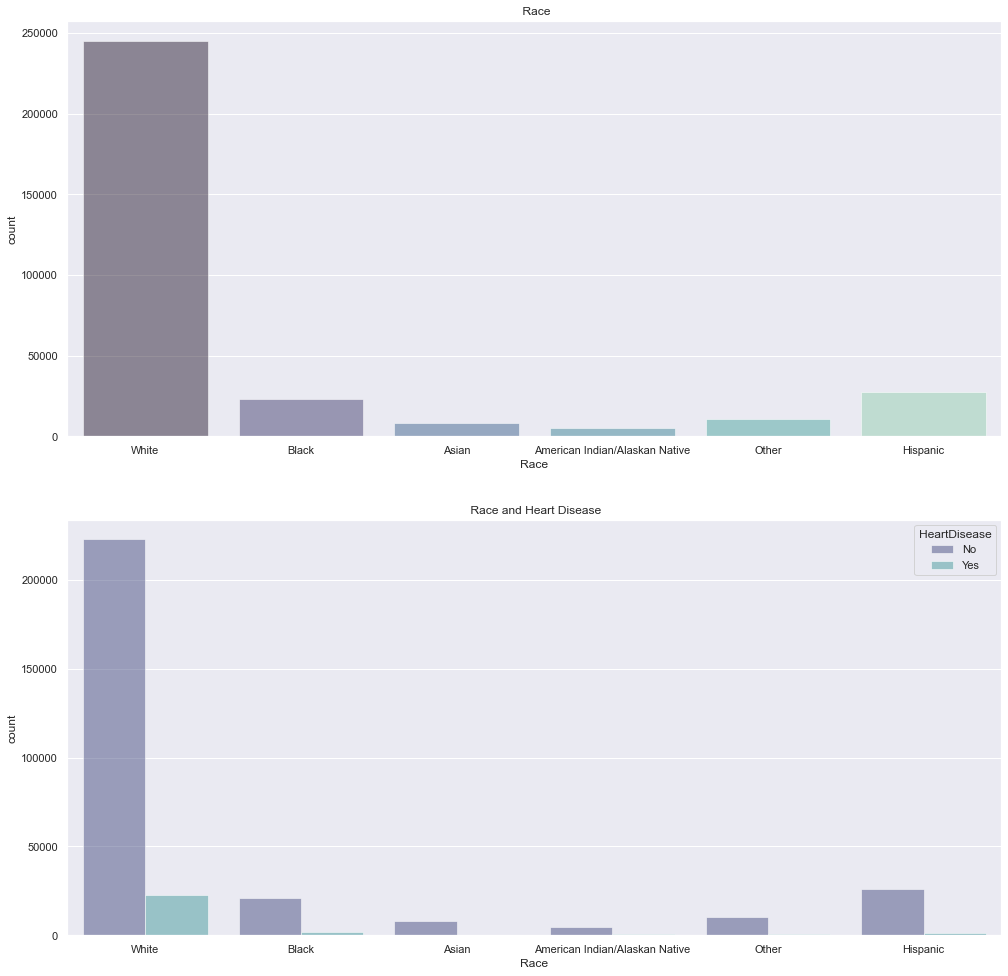

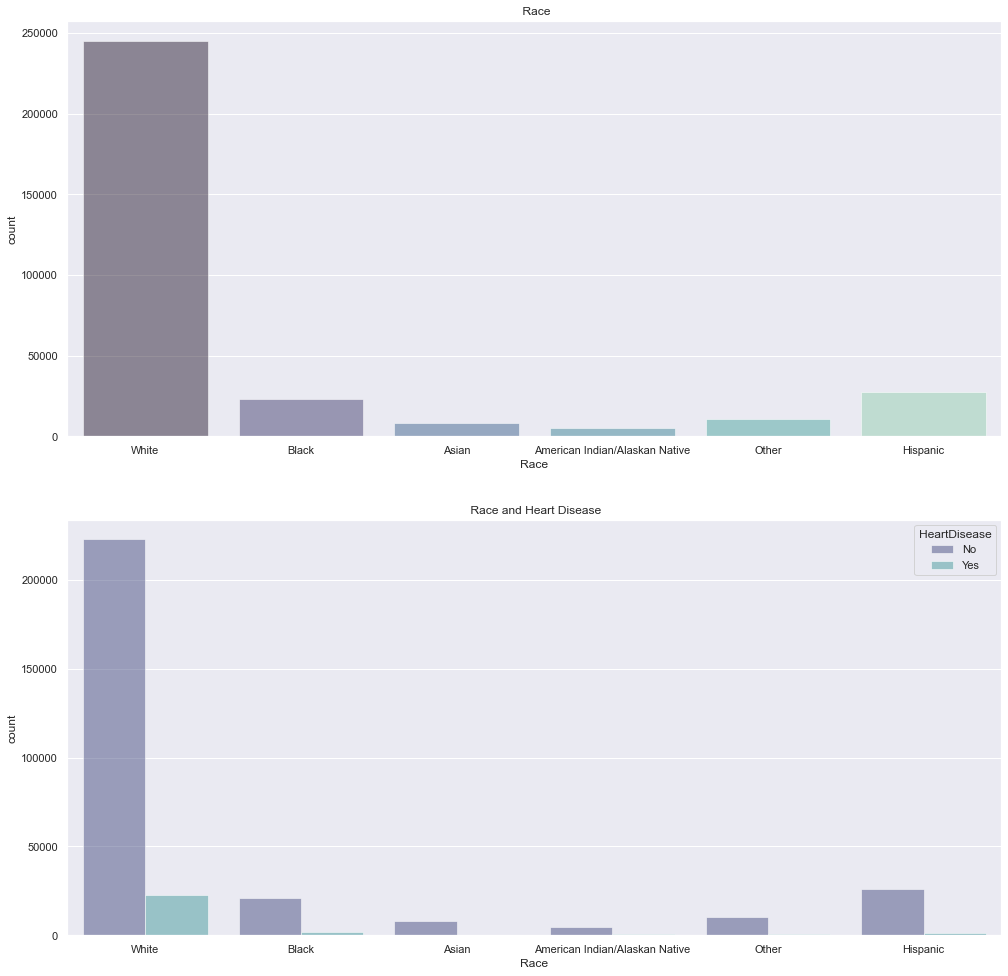

In [ ]:
plt.figure(figsize=(35,26))
sns.set(font_scale = 1, style = 'darkgrid')
ax= [None for _ in range(2)]

ax[0] = plt.subplot2grid((3,4), (0,0), colspan = 2)
ax[1] = plt.subplot2grid((3,4), (1,0), colspan = 2)


sns.countplot(data=dataset, x='Race',palette='mako',alpha = 0.5, ax=ax[0])
sns.countplot(data=dataset, x='Race',palette='mako', hue = 'HeartDisease', alpha = 0.5, ax=ax[1])

ax[0].set_title(' Race')
ax[1].set_title(' Race and Heart Disease')
plt.show()

In [ ]:
dataset.Diabetic.value_counts()

No                         269653
Yes                         40802
No, borderline diabetes      6781
Yes (during pregnancy)       2559
Name: Diabetic, dtype: int64

No                         269653
Yes                         40802
No, borderline diabetes      6781
Yes (during pregnancy)       2559
Name: Diabetic, dtype: int64

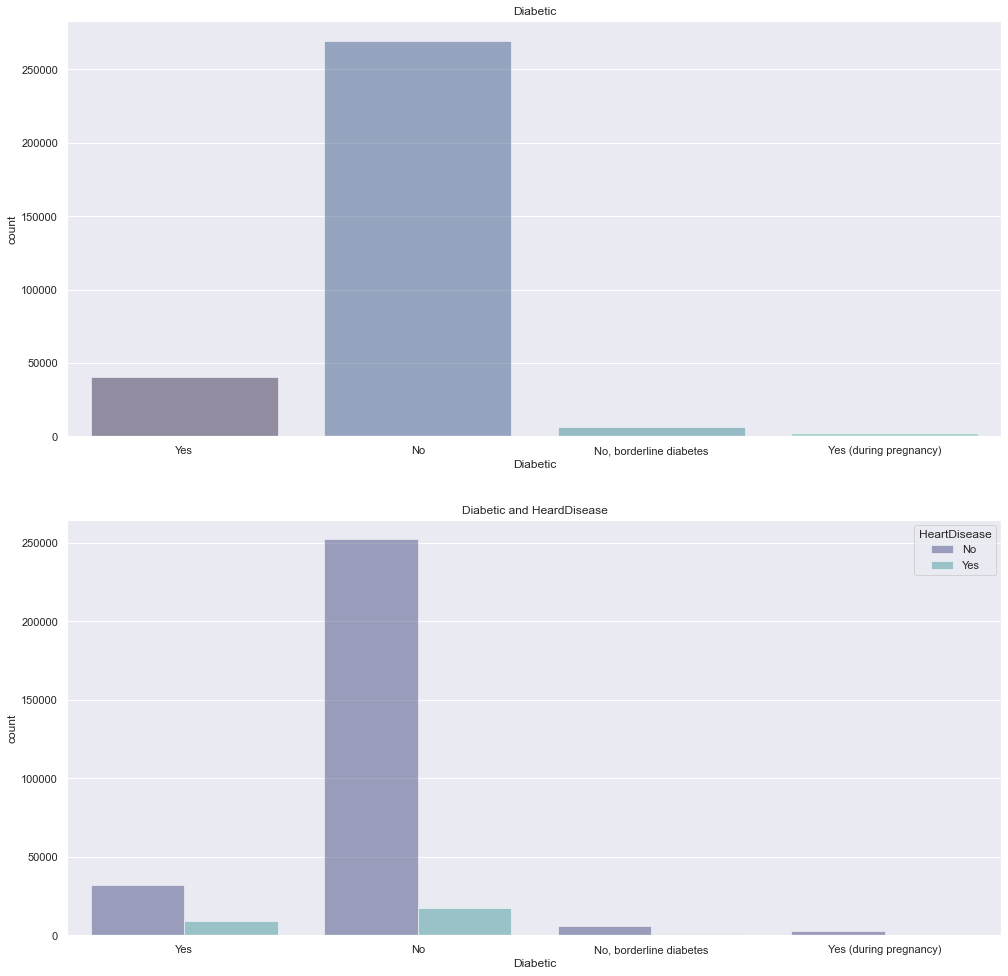

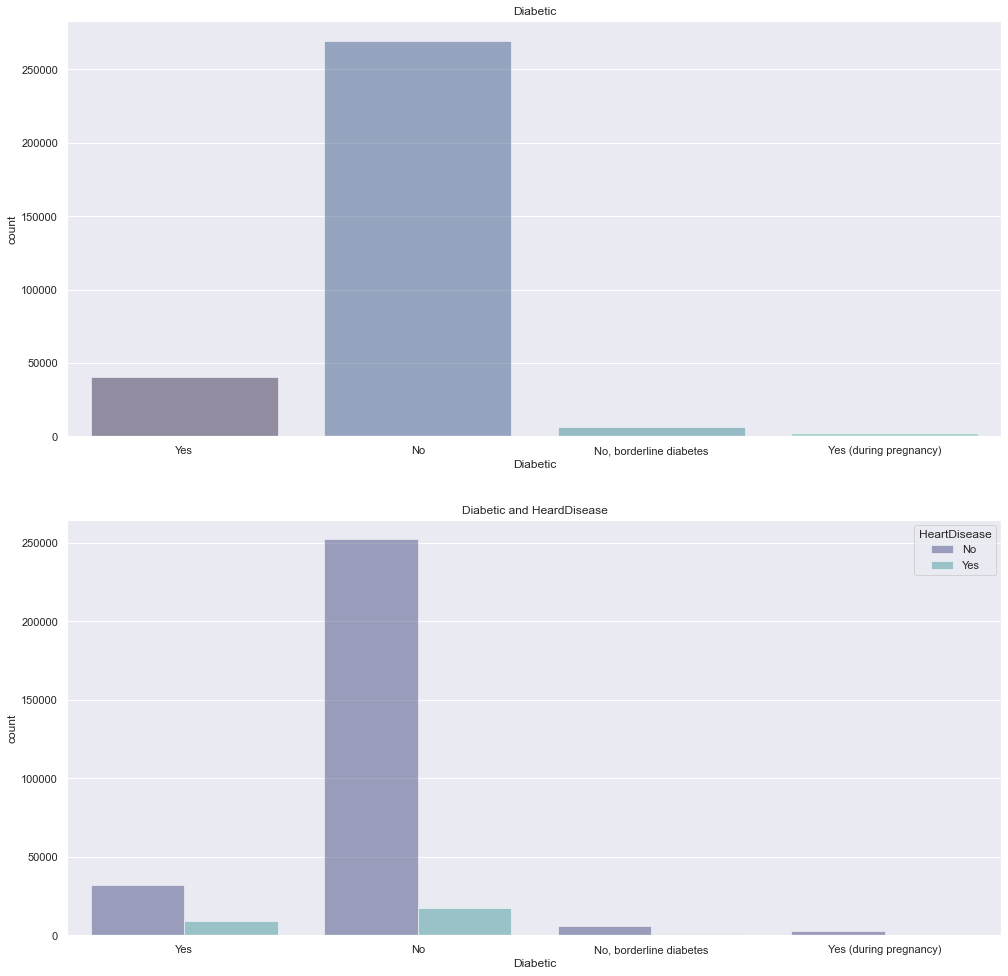

In [ ]:
plt.figure(figsize=(35,26))
sns.set(font_scale = 1, style = 'darkgrid')
ax= [None for _ in range(2)]

ax[0] = plt.subplot2grid((3,4), (0,0), colspan = 2)
ax[1] = plt.subplot2grid((3,4), (1,0), colspan = 2)


sns.countplot(data=dataset, x='Diabetic',palette='mako',alpha = 0.5, ax=ax[0])
sns.countplot(data=dataset, x='Diabetic',palette='mako', hue = 'HeartDisease', alpha = 0.5, ax=ax[1])

ax[0].set_title('Diabetic')
ax[1].set_title('Diabetic and HeardDisease')
plt.show()

In [ ]:
dataset.PhysicalActivity.value_counts()

Yes    247957
No      71838
Name: PhysicalActivity, dtype: int64

Yes    247957
No      71838
Name: PhysicalActivity, dtype: int64

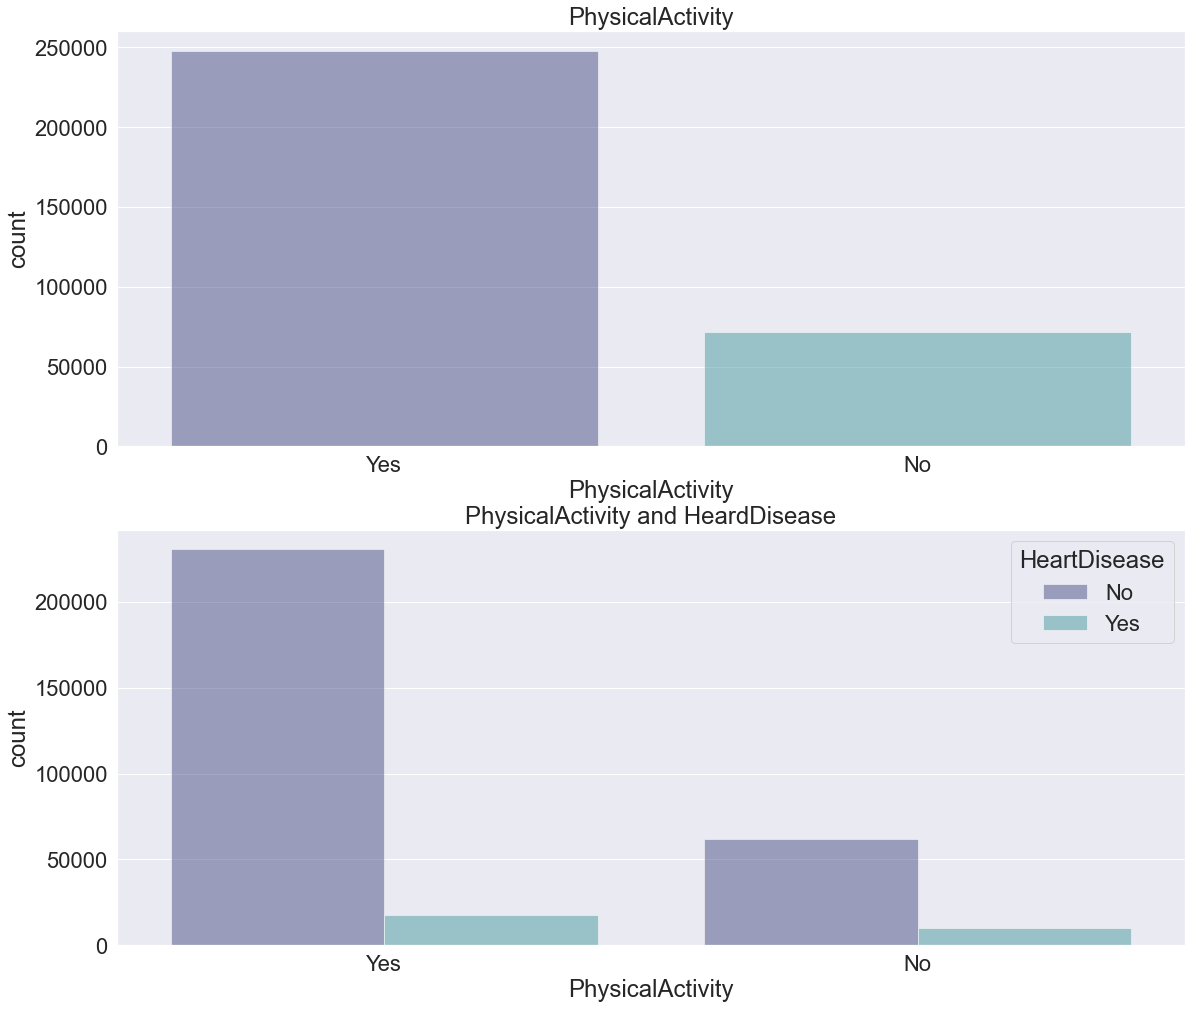

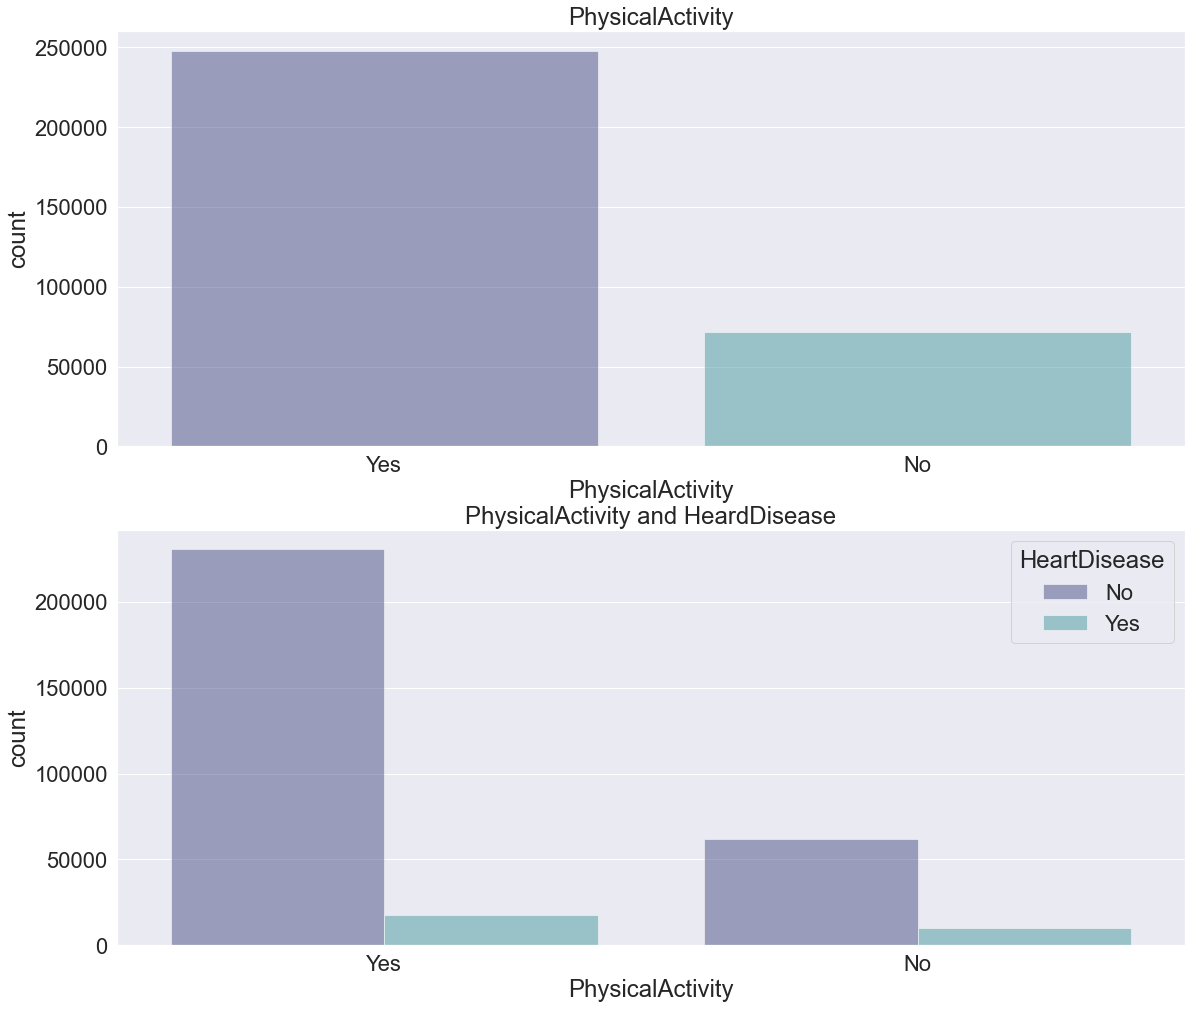

In [ ]:
plt.figure(figsize=(40,26))
sns.set(font_scale = 2, style = 'darkgrid')
ax= [None for _ in range(2)]

ax[0] = plt.subplot2grid((3,4), (0,0), colspan = 2)
ax[1] = plt.subplot2grid((3,4), (1,0), colspan = 2)


sns.countplot(data=dataset, x='PhysicalActivity',palette='mako',alpha = 0.5, ax=ax[0])
sns.countplot(data=dataset, x='PhysicalActivity',palette='mako', hue = 'HeartDisease', alpha = 0.5, ax=ax[1])

ax[0].set_title('PhysicalActivity')
ax[1].set_title('PhysicalActivity and HeardDisease')
plt.show()

In [ ]:
dataset.GenHealth.value_counts()

Very good    113858
Good          93129
Excellent     66842
Fair          34677
Poor          11289
Name: GenHealth, dtype: int64

Very good    113858
Good          93129
Excellent     66842
Fair          34677
Poor          11289
Name: GenHealth, dtype: int64

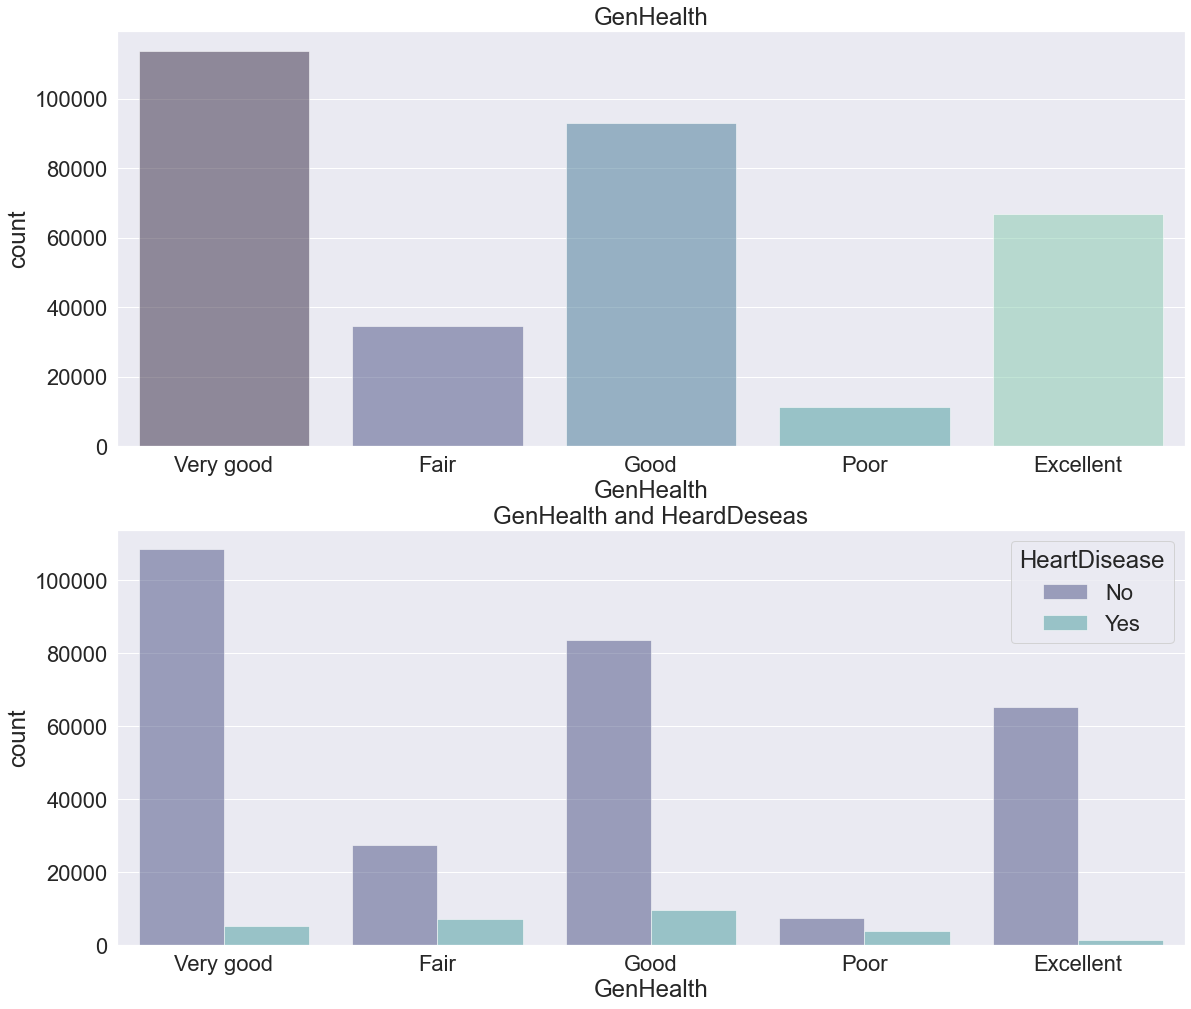

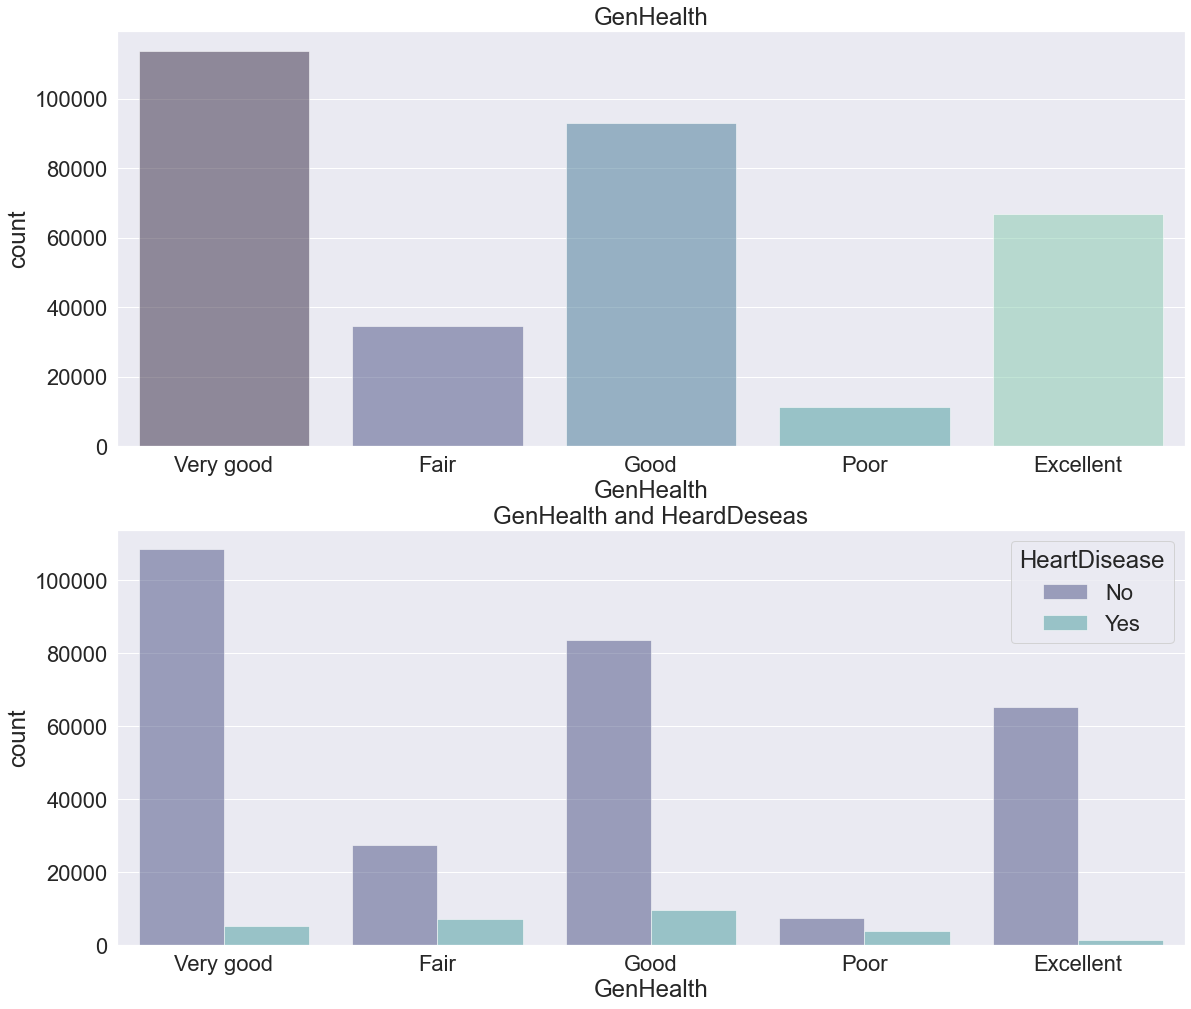

In [ ]:
plt.figure(figsize=(40,26))
sns.set(font_scale = 2, style = 'darkgrid')
ax= [None for _ in range(2)]

ax[0] = plt.subplot2grid((3,4), (0,0), colspan = 2)
ax[1] = plt.subplot2grid((3,4), (1,0), colspan = 2)


sns.countplot(data=dataset, x='GenHealth',palette='mako',alpha = 0.5, ax=ax[0])
sns.countplot(data=dataset, x='GenHealth',palette='mako', hue = 'HeartDisease', alpha = 0.5, ax=ax[1])

ax[0].set_title('GenHealth')
ax[1].set_title('GenHealth and HeardDeseas')
plt.show()

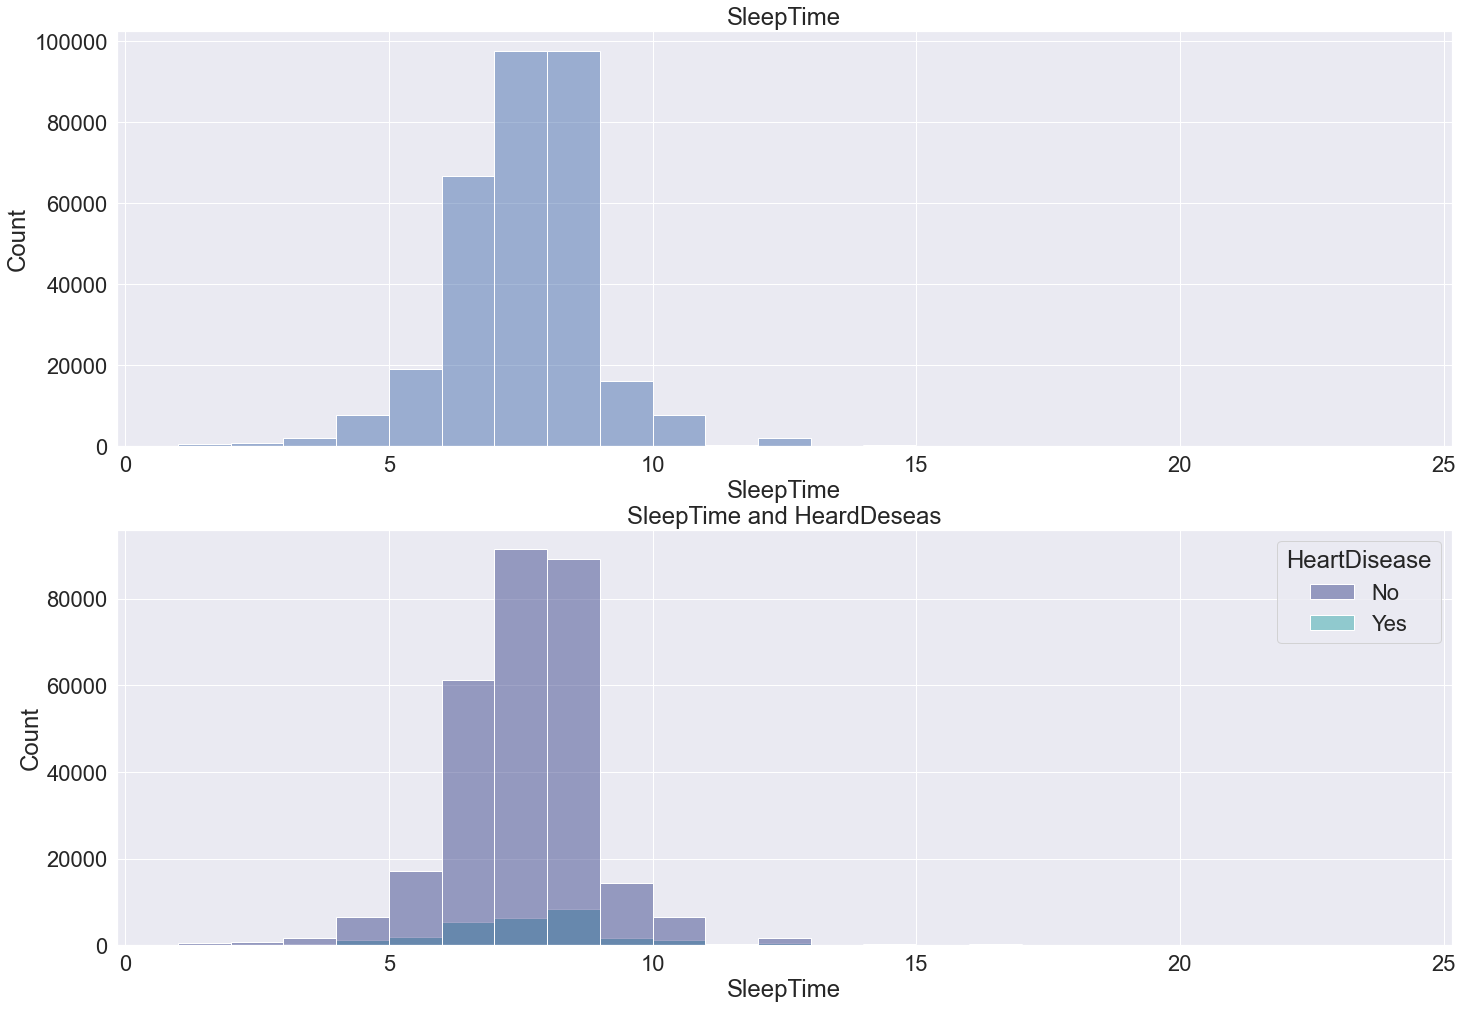

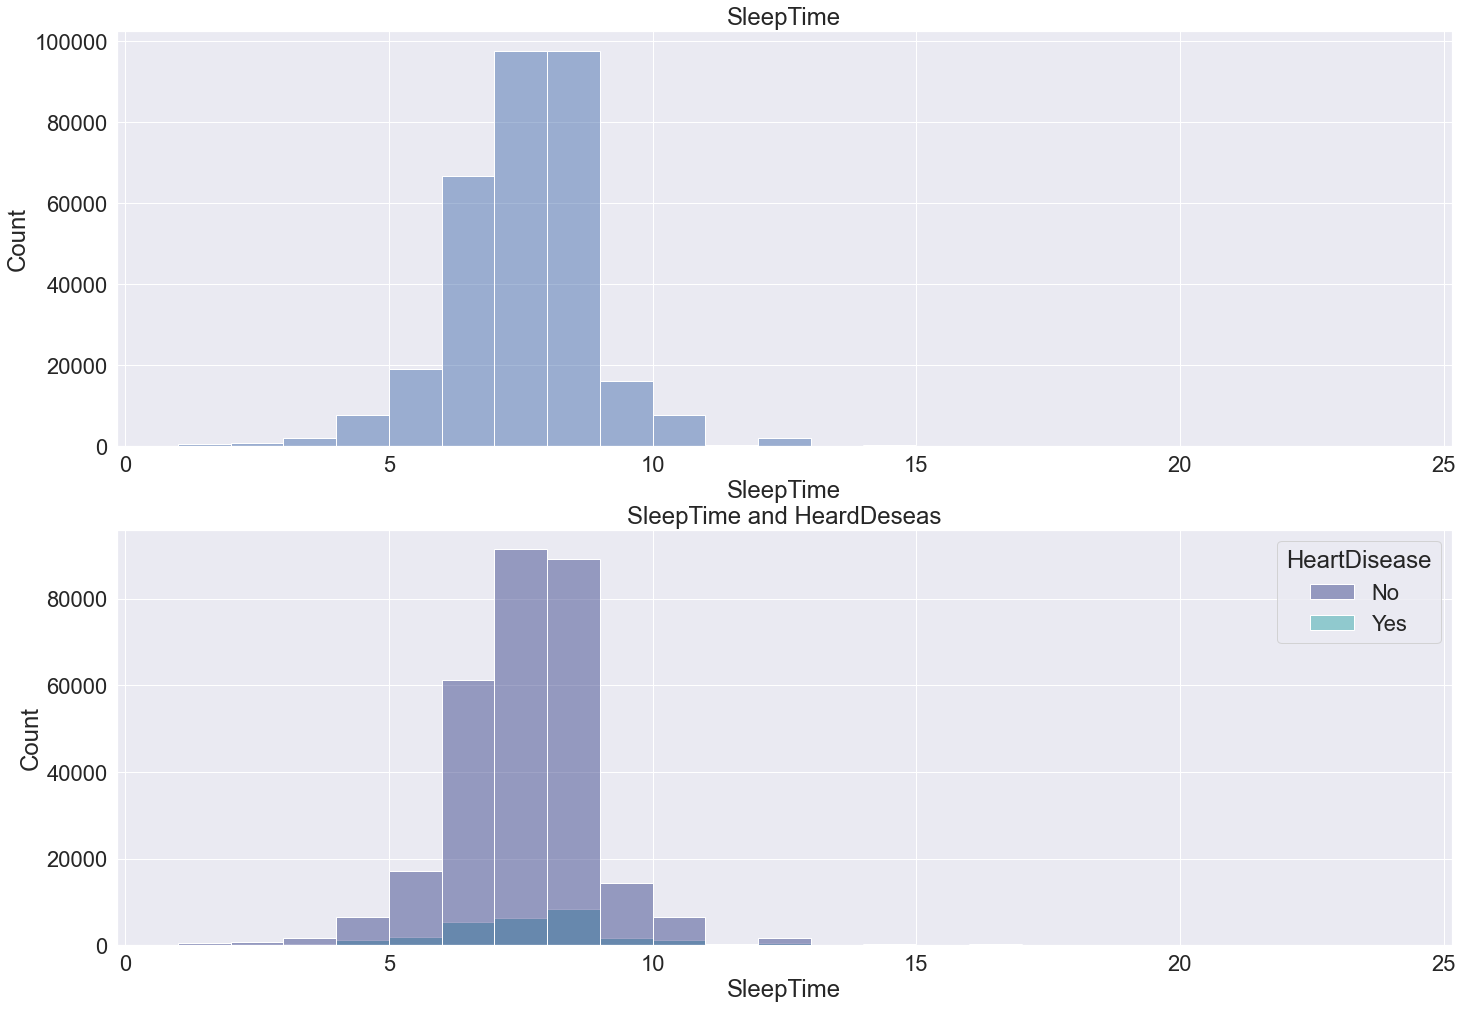

In [ ]:
plt.figure(figsize=(50,26))
sns.set(font_scale = 2, style = 'darkgrid')
ax= [None for _ in range(2)]

ax[0] = plt.subplot2grid((3,4), (0,0), colspan = 2)
ax[1] = plt.subplot2grid((3,4), (1,0), colspan = 2)


sns.histplot(data= dataset, x = "SleepTime",palette='mako',alpha = 0.5 ,binwidth = 1, ax=ax[0])
sns.histplot(data= dataset, x = "SleepTime",palette='mako',alpha = 0.5 ,binwidth = 1, ax=ax[1],hue = 'HeartDisease')
ax[0].set_title('SleepTime')
ax[1].set_title('SleepTime and HeardDeseas')
plt.show()

In [ ]:
dataset.Asthma.value_counts()

No     276923
Yes     42872
Name: Asthma, dtype: int64

No     276923
Yes     42872
Name: Asthma, dtype: int64

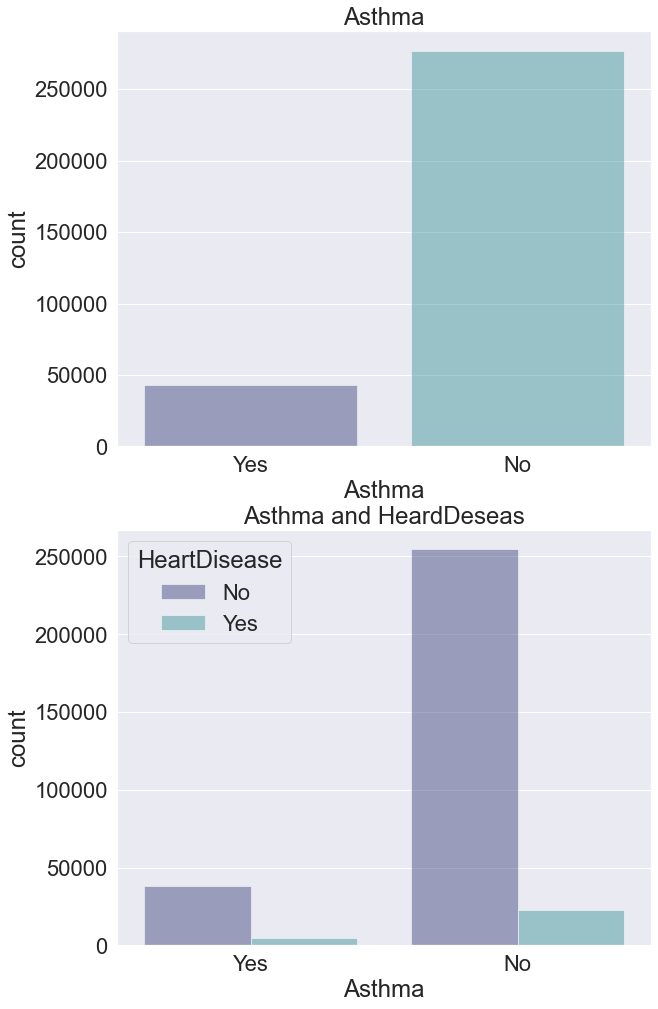

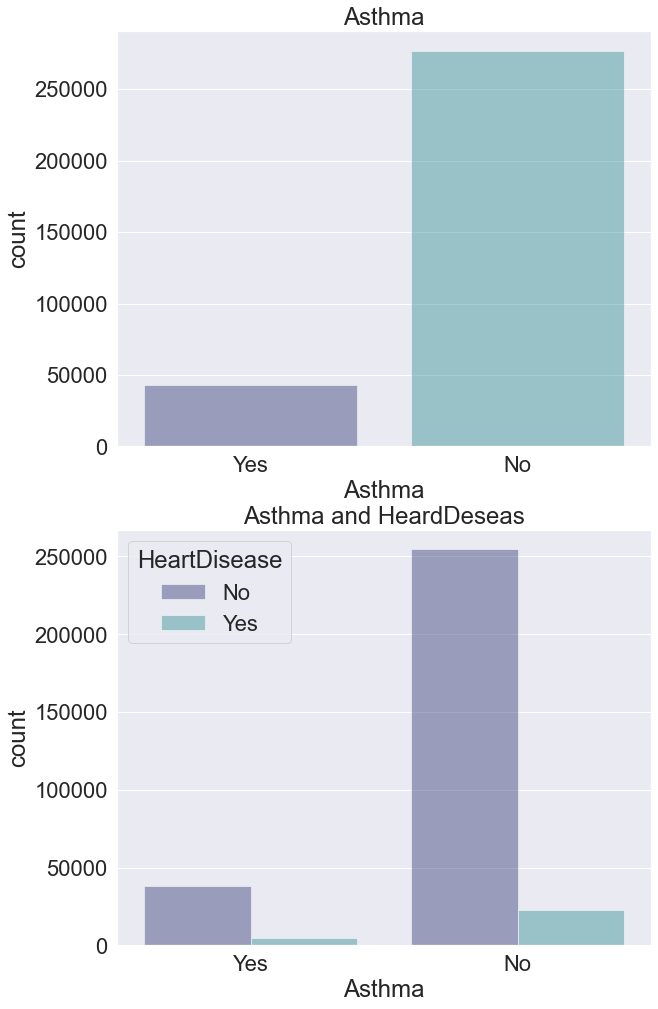

In [ ]:
plt.figure(figsize=( 20 ,26))
sns.set(font_scale = 2, style = 'darkgrid')
ax= [None for _ in range(2)]

ax[0] = plt.subplot2grid((3,4), (0,0), colspan = 2)
ax[1] = plt.subplot2grid((3,4), (1,0), colspan = 2)


sns.countplot(data=dataset, x='Asthma',palette='mako',alpha = 0.5, ax=ax[0])
sns.countplot(data=dataset, x='Asthma',palette='mako', hue = 'HeartDisease', alpha = 0.5, ax=ax[1])

ax[0].set_title('Asthma')
ax[1].set_title('Asthma and HeardDeseas')
plt.show()

In [ ]:
dataset.KidneyDisease.value_counts()

No     308016
Yes     11779
Name: KidneyDisease, dtype: int64

No     308016
Yes     11779
Name: KidneyDisease, dtype: int64

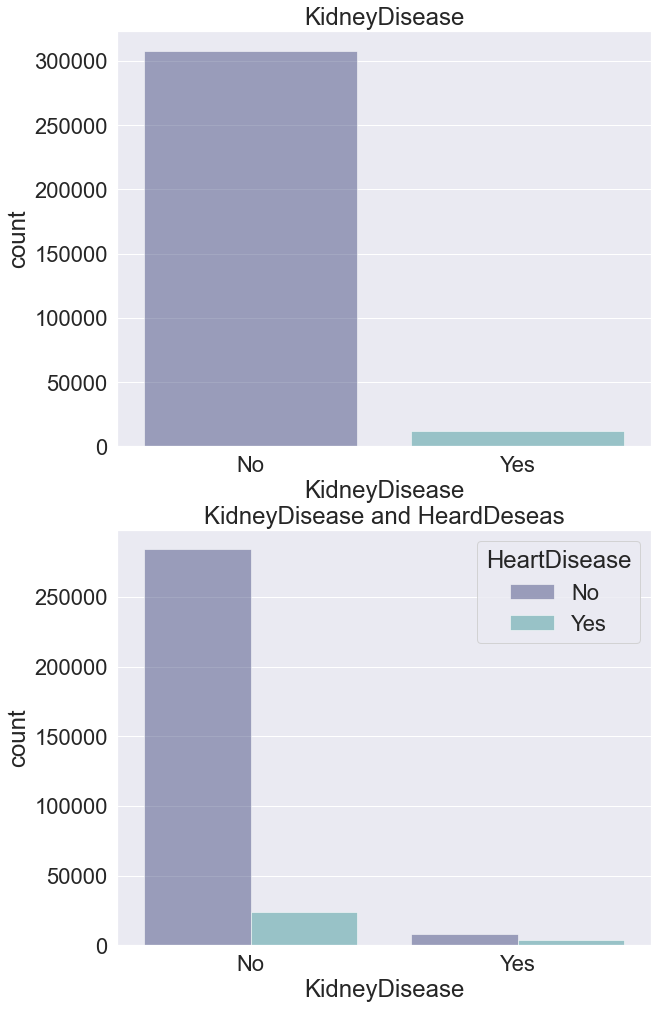

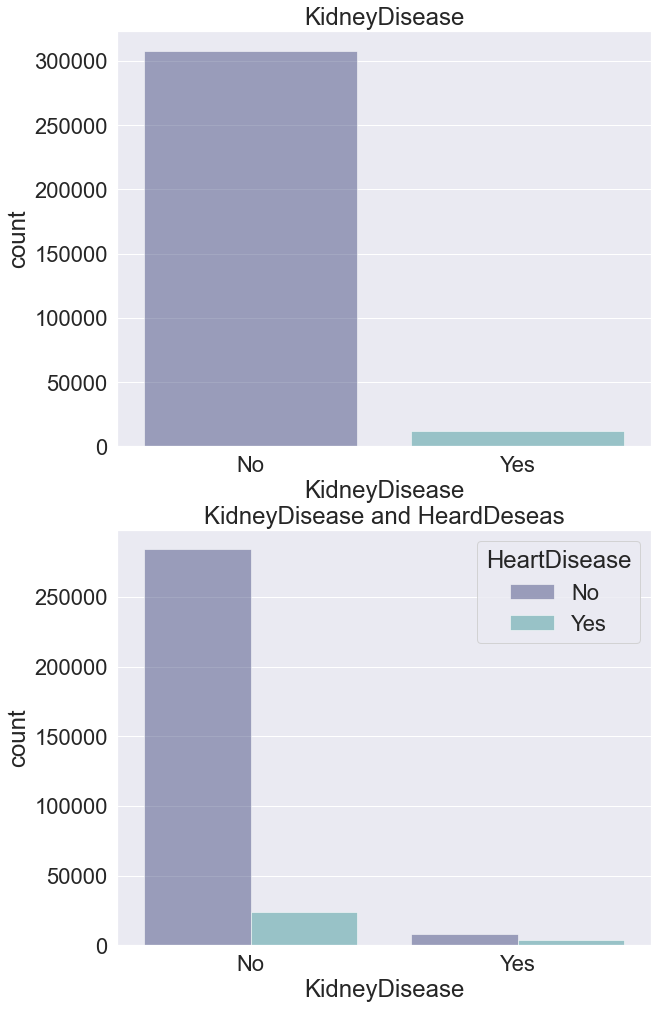

In [ ]:
plt.figure(figsize=( 20 ,26))
sns.set(font_scale = 2, style = 'darkgrid')
ax= [None for _ in range(2)]

ax[0] = plt.subplot2grid((3,4), (0,0), colspan = 2)
ax[1] = plt.subplot2grid((3,4), (1,0), colspan = 2)


sns.countplot(data=dataset, x='KidneyDisease',palette='mako',alpha = 0.5, ax=ax[0])
sns.countplot(data=dataset, x='KidneyDisease',palette='mako', hue = 'HeartDisease', alpha = 0.5, ax=ax[1])

ax[0].set_title('KidneyDisease')
ax[1].set_title('KidneyDisease and HeardDeseas')
plt.show()

In [ ]:
dataset.SkinCancer.value_counts()

No     289976
Yes     29819
Name: SkinCancer, dtype: int64

No     289976
Yes     29819
Name: SkinCancer, dtype: int64

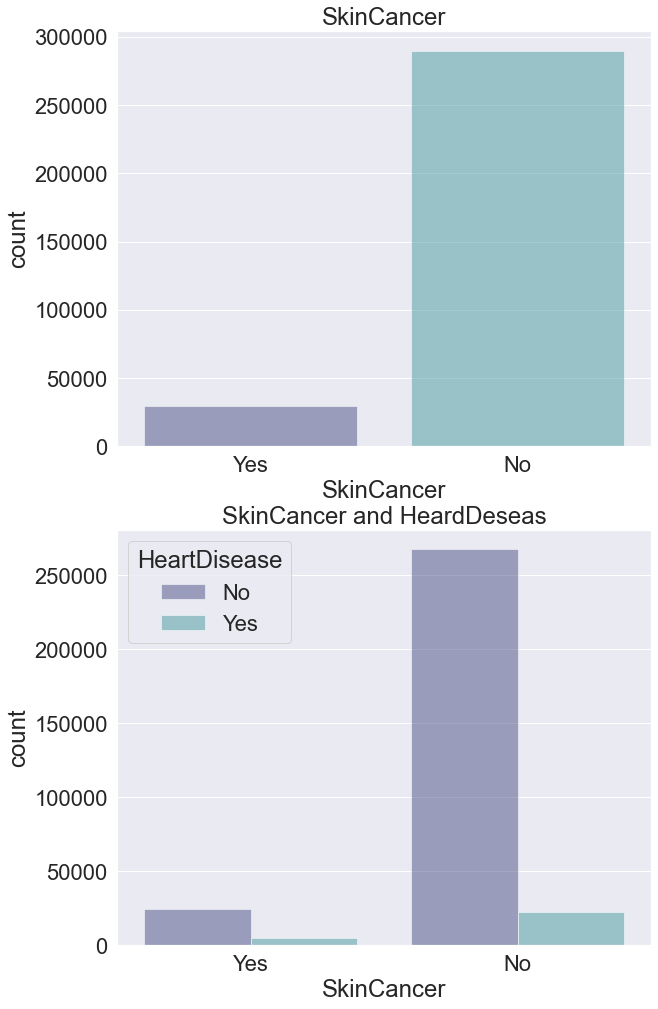

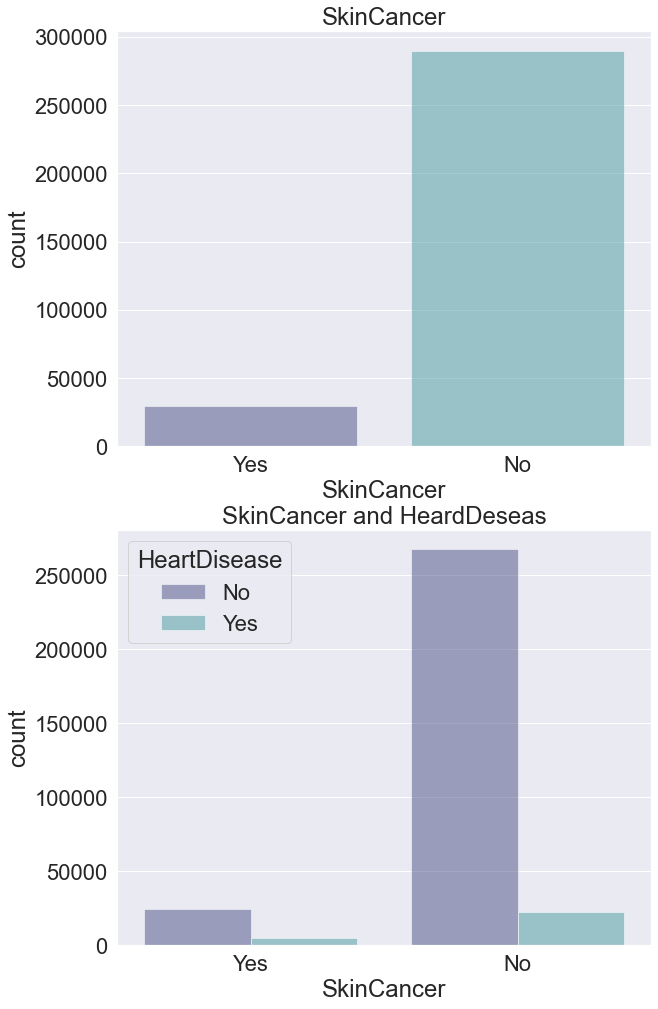

In [ ]:
plt.figure(figsize=( 20 ,26))
sns.set(font_scale = 2, style = 'darkgrid')
ax= [None for _ in range(2)]

ax[0] = plt.subplot2grid((3,4), (0,0), colspan = 2)
ax[1] = plt.subplot2grid((3,4), (1,0), colspan = 2)


sns.countplot(data=dataset, x='SkinCancer',palette='mako',alpha = 0.5, ax=ax[0])
sns.countplot(data=dataset, x='SkinCancer',palette='mako', hue = 'HeartDisease', alpha = 0.5, ax=ax[1])

ax[0].set_title('SkinCancer')
ax[1].set_title('SkinCancer and HeardDeseas')
plt.show()

In [ ]:
# Enhanced Data Preprocessing and Feature Engineering
print("=== DATA PREPROCESSING ===")

# 1. Check for missing values
print("Missing values:")
missing_values = dataset.isnull().sum()
print(missing_values[missing_values > 0])

# 2. Create a copy for preprocessing
df_processed = dataset.copy()

# 3. Feature Engineering
print("\n=== FEATURE ENGINEERING ===")

# Create BMI categories
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal'
    elif 25 <= bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

df_processed['BMI_Category'] = df_processed['BMI'].apply(categorize_bmi)

# Create age groups from AgeCategory
age_mapping = {
    '18-24': 21, '25-29': 27, '30-34': 32, '35-39': 37, '40-44': 42,
    '45-49': 47, '50-54': 52, '55-59': 57, '60-64': 62, '65-69': 67,
    '70-74': 72, '75-79': 77, '80 or older': 85
}
df_processed['Age_Numeric'] = df_processed['AgeCategory'].map(age_mapping)

# Create health score (combination of physical and mental health)
df_processed['Health_Score'] = (df_processed['PhysicalHealth'] + df_processed['MentalHealth']) / 2

# Create risk score (sum of risk factors)
risk_factors = ['Smoking', 'AlcoholDrinking', 'Stroke', 'Diabetic', 'Asthma', 'KidneyDisease', 'SkinCancer']
df_processed['Risk_Score'] = 0
for factor in risk_factors:
    if factor in df_processed.columns:
        df_processed['Risk_Score'] += (df_processed[factor] == 'Yes').astype(int)

print("New features created:")
print("- BMI_Category: Categorized BMI levels")
print("- Age_Numeric: Numeric age representation")
print("- Health_Score: Combined physical and mental health")
print("- Risk_Score: Sum of risk factors")

# Display new features
print(f"\nBMI Category distribution:")
print(df_processed['BMI_Category'].value_counts())
print(f"\nRisk Score distribution:")
print(df_processed['Risk_Score'].value_counts().sort_index())

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

In [ ]:
# Enhanced Label Encoding and Data Preparation
print("=== LABEL ENCODING ===")

# Identify categorical columns
categorical_columns = df_processed.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns to encode: {categorical_columns}")

# Create a copy for encoding
df_encoded = df_processed.copy()

# Apply label encoding to categorical variables
label_encoders = {}
for col in categorical_columns:
    if col != 'HeartDisease':  # Don't encode target variable yet
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        label_encoders[col] = le
        print(f"Encoded {col}: {le.classes_}")

# Encode target variable
target_encoder = LabelEncoder()
df_encoded['HeartDisease'] = target_encoder.fit_transform(df_encoded['HeartDisease'])
print(f"Encoded HeartDisease: {target_encoder.classes_}")

print(f"\nDataset shape after encoding: {df_encoded.shape}")
print(f"Data types after encoding:")
print(df_encoded.dtypes.value_counts())

In [ ]:
dataset

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3.0,30.0,0,0,7,5,2,1,4,5.0,1,0,1
1,0,20.34,0,0,1,0.0,0.0,0,0,12,5,0,1,4,7.0,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,1,9,5,2,1,1,8.0,1,0,0
3,0,24.21,0,0,0,0.0,0.0,0,0,11,5,0,0,2,6.0,0,0,1
4,0,23.71,0,0,0,28.0,0.0,1,0,4,5,0,1,4,8.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,1,27.41,1,0,0,7.0,0.0,1,1,8,3,2,0,1,6.0,1,0,0
319791,0,29.84,1,0,0,0.0,0.0,0,1,3,3,0,1,4,5.0,1,0,0
319792,0,24.24,0,0,0,0.0,0.0,0,0,5,3,0,1,2,6.0,0,0,0
319793,0,32.81,0,0,0,0.0,0.0,0,0,1,3,0,0,2,12.0,0,0,0


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3.0,30.0,0,0,7,5,2,1,4,5.0,1,0,1
1,0,20.34,0,0,1,0.0,0.0,0,0,12,5,0,1,4,7.0,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,1,9,5,2,1,1,8.0,1,0,0
3,0,24.21,0,0,0,0.0,0.0,0,0,11,5,0,0,2,6.0,0,0,1
4,0,23.71,0,0,0,28.0,0.0,1,0,4,5,0,1,4,8.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,1,27.41,1,0,0,7.0,0.0,1,1,8,3,2,0,1,6.0,1,0,0
319791,0,29.84,1,0,0,0.0,0.0,0,1,3,3,0,1,4,5.0,1,0,0
319792,0,24.24,0,0,0,0.0,0.0,0,0,5,3,0,1,2,6.0,0,0,0
319793,0,32.81,0,0,0,0.0,0.0,0,0,1,3,0,0,2,12.0,0,0,0


In [ ]:
# Enhanced Feature Scaling
print("=== FEATURE SCALING ===")

# Separate features and target
X = df_encoded.drop('HeartDisease', axis=1)
y = df_encoded['HeartDisease']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target distribution: {np.bincount(y)}")

# Apply MinMaxScaler for better performance
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print(f"Scaled features shape: {X_scaled.shape}")
print(f"Scaled features statistics:")
print(X_scaled.describe())

In [ ]:
# Advanced Class Imbalance Handling
print("=== ADVANCED DATA BALANCING ===")

# Check class distribution
class_counts = np.bincount(y)
print(f"Original class distribution: {class_counts}")
print(f"Class imbalance ratio: {class_counts[1]/class_counts[0]:.3f}")

# Method 1: SMOTE (Synthetic Minority Oversampling Technique)
print("\n--- Method 1: SMOTE ---")
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_scaled, y)
print(f"SMOTE dataset shape: {X_smote.shape}")
print(f"SMOTE target distribution: {np.bincount(y_smote)}")

# Method 2: ADASYN (Adaptive Synthetic Sampling)
print("\n--- Method 2: ADASYN ---")
adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X_scaled, y)
print(f"ADASYN dataset shape: {X_adasyn.shape}")
print(f"ADASYN target distribution: {np.bincount(y_adasyn)}")

# Method 3: SMOTE + Tomek Links (Combined approach)
print("\n--- Method 3: SMOTE + Tomek Links ---")
smote_tomek = SMOTETomek(random_state=42)
X_smote_tomek, y_smote_tomek = smote_tomek.fit_resample(X_scaled, y)
print(f"SMOTE+Tomek dataset shape: {X_smote_tomek.shape}")
print(f"SMOTE+Tomek target distribution: {np.bincount(y_smote_tomek)}")

# Method 4: Random Undersampling
print("\n--- Method 4: Random Undersampling ---")
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X_scaled, y)
print(f"Undersampled dataset shape: {X_under.shape}")
print(f"Undersampled target distribution: {np.bincount(y_under)}")

# Compare different balancing methods
balancing_methods = {
    'Original': (X_scaled, y),
    'SMOTE': (X_smote, y_smote),
    'ADASYN': (X_adasyn, y_adasyn),
    'SMOTE+Tomek': (X_smote_tomek, y_smote_tomek),
    'Undersampled': (X_under, y_under)
}

# Visualize class distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, (method_name, (X_bal, y_bal)) in enumerate(balancing_methods.items()):
    if i < len(axes):
        class_counts = np.bincount(y_bal)
        axes[i].pie(class_counts, labels=['No Heart Disease', 'Heart Disease'], 
                   autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
        axes[i].set_title(f'{method_name}\n({len(X_bal)} samples)')

# Hide unused subplot
if len(balancing_methods) < len(axes):
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

# Use SMOTE as the primary balancing method (typically performs best)
X_balanced = X_smote
y_balanced = y_smote
print(f"\nSelected SMOTE for primary balancing")
print(f"Final balanced dataset: {X_balanced.shape}")

In [ ]:
# Advanced Feature Selection and Engineering
print("=== ADVANCED FEATURE SELECTION ===")

# 1. Statistical Feature Selection (F-test)
print("--- Statistical Feature Selection (F-test) ---")
selector_f = SelectKBest(score_func=f_classif, k=15)
X_selected_f = selector_f.fit_transform(X_balanced, y_balanced)
selected_features_f = X_balanced.columns[selector_f.get_support()].tolist()
print(f"Selected features (F-test): {selected_features_f}")

# 2. Recursive Feature Elimination with Random Forest
print("\n--- Recursive Feature Elimination ---")
rf_selector = RandomForestClassifier(n_estimators=50, random_state=42)
rfe = RFE(estimator=rf_selector, n_features_to_select=15)
X_selected_rfe = rfe.fit_transform(X_balanced, y_balanced)
selected_features_rfe = X_balanced.columns[rfe.get_support()].tolist()
print(f"Selected features (RFE): {selected_features_rfe}")

# 3. Feature Importance from Random Forest
print("\n--- Feature Importance Analysis ---")
rf_importance = RandomForestClassifier(n_estimators=100, random_state=42)
rf_importance.fit(X_balanced, y_balanced)
feature_importance_df = pd.DataFrame({
    'feature': X_balanced.columns,
    'importance': rf_importance.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 most important features:")
print(feature_importance_df.head(15))

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(15)
sns.barplot(data=top_features, x='importance', y='feature')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# 4. Correlation-based Feature Selection
print("\n--- Correlation Analysis ---")
correlation_matrix = X_balanced.corr()
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

print(f"High correlation pairs (>0.8): {len(high_corr_pairs)}")
for pair in high_corr_pairs[:5]:  # Show first 5
    print(f"  {pair[0]} - {pair[1]}: {pair[2]:.3f}")

# Use RFE selected features for further analysis
X_final = X_selected_rfe
selected_features = selected_features_rfe
print(f"\nFinal selected features: {len(selected_features)}")
print(f"Features: {selected_features}")


In [ ]:
dataset

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,0.055294,1,0,0,0.100000,1.0,0,0,0.583333,1.0,0.666667,1,1.00,0.173913,1,0,1
1,0,0.100447,0,0,1,0.000000,0.0,0,0,1.000000,1.0,0.000000,1,1.00,0.260870,0,0,0
2,0,0.175782,1,0,0,0.666667,1.0,0,1,0.750000,1.0,0.666667,1,0.25,0.304348,1,0,0
3,0,0.147169,0,0,0,0.000000,0.0,0,0,0.916667,1.0,0.000000,0,0.50,0.217391,0,0,1
4,0,0.141132,0,0,0,0.933333,0.0,1,0,0.333333,1.0,0.000000,1,1.00,0.304348,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,1,0.185802,1,0,0,0.233333,0.0,1,1,0.666667,0.6,0.666667,0,0.25,0.217391,1,0,0
319791,0,0.215139,1,0,0,0.000000,0.0,0,1,0.250000,0.6,0.000000,1,1.00,0.173913,1,0,0
319792,0,0.147531,0,0,0,0.000000,0.0,0,0,0.416667,0.6,0.000000,1,0.50,0.217391,0,0,0
319793,0,0.250996,0,0,0,0.000000,0.0,0,0,0.083333,0.6,0.000000,0,0.50,0.478261,0,0,0


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,0.055294,1,0,0,0.100000,1.0,0,0,0.583333,1.0,0.666667,1,1.00,0.173913,1,0,1
1,0,0.100447,0,0,1,0.000000,0.0,0,0,1.000000,1.0,0.000000,1,1.00,0.260870,0,0,0
2,0,0.175782,1,0,0,0.666667,1.0,0,1,0.750000,1.0,0.666667,1,0.25,0.304348,1,0,0
3,0,0.147169,0,0,0,0.000000,0.0,0,0,0.916667,1.0,0.000000,0,0.50,0.217391,0,0,1
4,0,0.141132,0,0,0,0.933333,0.0,1,0,0.333333,1.0,0.000000,1,1.00,0.304348,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,1,0.185802,1,0,0,0.233333,0.0,1,1,0.666667,0.6,0.666667,0,0.25,0.217391,1,0,0
319791,0,0.215139,1,0,0,0.000000,0.0,0,1,0.250000,0.6,0.000000,1,1.00,0.173913,1,0,0
319792,0,0.147531,0,0,0,0.000000,0.0,0,0,0.416667,0.6,0.000000,1,0.50,0.217391,0,0,0
319793,0,0.250996,0,0,0,0.000000,0.0,0,0,0.083333,0.6,0.000000,0,0.50,0.478261,0,0,0


In [ ]:
# Enhanced Train-Test Split
print("=== TRAIN-TEST SPLIT ===")

# Use balanced dataset for training
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_balanced
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training target distribution: {np.bincount(y_train.astype(int))}")
print(f"Test target distribution: {np.bincount(y_test.astype(int))}")

# Also create a test set from original data for realistic evaluation
X_orig_test, y_orig_test = train_test_split(
    X_scaled, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Original test set shape: {X_orig_test.shape}")
print(f"Original test target distribution: {np.bincount(y_orig_test)}")

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.02, random_state= 42)

In [ ]:
X_test_ = X_test.copy()
y_test_ = y_test.copy()

In [ ]:
# Advanced Model Training with Multiple Algorithms
print("=== ADVANCED MODEL TRAINING ===")

# Define comprehensive model suite
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(random_state=42, verbose=-1),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42, probability=True),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Class weights for imbalanced data
class_weights = {
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=len(y_balanced[y_balanced==0])/len(y_balanced[y_balanced==1])),
    'LightGBM': lgb.LGBMClassifier(random_state=42, verbose=-1, class_weight='balanced'),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'SVM': SVC(random_state=42, probability=True, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced')
}

print("Models with class weights created for imbalanced data handling")

# Train and evaluate models
model_results = {}
trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    model.fit(X_train, y_train)
    trained_models[name] = model
    
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_pred_orig = model.predict(X_orig_test)
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    orig_accuracy = accuracy_score(y_orig_test, y_pred_orig)
    
    train_f1 = f1_score(y_train, y_pred_train)
    test_f1 = f1_score(y_test, y_pred_test)
    orig_f1 = f1_score(y_orig_test, y_pred_orig)
    
    train_precision = precision_score(y_train, y_pred_train)
    test_precision = precision_score(y_test, y_pred_test)
    orig_precision = precision_score(y_orig_test, y_pred_orig)
    
    train_recall = recall_score(y_train, y_pred_train)
    test_recall = recall_score(y_test, y_pred_test)
    orig_recall = recall_score(y_orig_test, y_pred_orig)
    
    # Store results
    model_results[name] = {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'orig_accuracy': orig_accuracy,
        'train_f1': train_f1,
        'test_f1': test_f1,
        'orig_f1': orig_f1,
        'train_precision': train_precision,
        'test_precision': test_precision,
        'orig_precision': orig_precision,
        'train_recall': train_recall,
        'test_recall': test_recall,
        'orig_recall': orig_recall
    }
    
    print(f"{name} Results:")
    print(f"  Balanced Test - Accuracy: {test_accuracy:.3f}, F1: {test_f1:.3f}")
    print(f"  Original Test - Accuracy: {orig_accuracy:.3f}, F1: {orig_f1:.3f}")

# Display results in a table
results_df = pd.DataFrame(model_results).T
print("\n=== MODEL COMPARISON ===")
print(results_df[['test_accuracy', 'test_f1', 'orig_accuracy', 'orig_f1']].round(3))

DecisionTreeClassifier()

DecisionTreeClassifier()

In [ ]:
# Advanced Hyperparameter Tuning with RandomizedSearchCV
print("=== ADVANCED HYPERPARAMETER TUNING ===")

# Define parameter grids for different models
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10, 15],
        'min_samples_leaf': [1, 2, 4, 8],
        'max_features': ['sqrt', 'log2', None]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [3, 4, 5, 6, 7],
        'learning_rate': [0.01, 0.1, 0.2, 0.3],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    },
    'LightGBM': {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [3, 4, 5, 6, 7],
        'learning_rate': [0.01, 0.1, 0.2, 0.3],
        'num_leaves': [31, 50, 100, 200],
        'subsample': [0.8, 0.9, 1.0]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [3, 4, 5, 6, 7],
        'learning_rate': [0.01, 0.1, 0.2, 0.3],
        'subsample': [0.8, 0.9, 1.0]
    }
}

# Perform hyperparameter tuning for top models
tuned_models = {}
tuning_results = {}

# Focus on top 3 models for tuning
top_models = ['Random Forest', 'XGBoost', 'LightGBM']

for model_name in top_models:
    print(f"\n--- Tuning {model_name} ---")
    
    if model_name in param_grids:
        # Use RandomizedSearchCV for faster tuning
        random_search = RandomizedSearchCV(
            models[model_name],
            param_grids[model_name],
            n_iter=20,  # Number of parameter settings sampled
            cv=3,  # 3-fold CV for speed
            scoring='f1',
            random_state=42,
            n_jobs=-1
        )
        
        # Fit the model
        random_search.fit(X_train, y_train)
        
        # Store results
        tuned_models[model_name] = random_search.best_estimator_
        tuning_results[model_name] = {
            'best_params': random_search.best_params_,
            'best_score': random_search.best_score_,
            'best_estimator': random_search.best_estimator_
        }
        
        print(f"Best parameters: {random_search.best_params_}")
        print(f"Best CV score: {random_search.best_score_:.3f}")
        
        # Evaluate on test sets
        y_pred_tuned = random_search.predict(X_test)
        y_pred_orig_tuned = random_search.predict(X_orig_test)
        
        test_f1 = f1_score(y_test, y_pred_tuned)
        orig_f1 = f1_score(y_orig_test, y_pred_orig_tuned)
        
        print(f"Test F1: {test_f1:.3f}, Original F1: {orig_f1:.3f}")

# Find best tuned model
best_tuned_model = max(tuning_results.keys(), key=lambda x: tuning_results[x]['best_score'])
print(f"\nBest tuned model: {best_tuned_model}")
print(f"Best CV score: {tuning_results[best_tuned_model]['best_score']:.3f}")

# Use best tuned model as final model
final_model = tuned_models[best_tuned_model]

In [ ]:
# Comprehensive K-Fold Cross-Validation
print("=== K-FOLD CROSS-VALIDATION EVALUATION ===")

# Define cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate all models with cross-validation
cv_results = {}
all_models = {**models, **tuned_models}

for model_name, model in all_models.items():
    print(f"\nEvaluating {model_name} with 5-fold CV...")
    
    # Cross-validation scores
    cv_accuracy = cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring='accuracy')
    cv_precision = cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring='precision')
    cv_recall = cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring='recall')
    cv_f1 = cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring='f1')
    cv_roc_auc = cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring='roc_auc')
    
    cv_results[model_name] = {
        'accuracy': {'mean': cv_accuracy.mean(), 'std': cv_accuracy.std()},
        'precision': {'mean': cv_precision.mean(), 'std': cv_precision.std()},
        'recall': {'mean': cv_recall.mean(), 'std': cv_recall.std()},
        'f1': {'mean': cv_f1.mean(), 'std': cv_f1.std()},
        'roc_auc': {'mean': cv_roc_auc.mean(), 'std': cv_roc_auc.std()}
    }
    
    print(f"  Accuracy: {cv_accuracy.mean():.3f} (+/- {cv_accuracy.std() * 2:.3f})")
    print(f"  F1-Score: {cv_f1.mean():.3f} (+/- {cv_f1.std() * 2:.3f})")
    print(f"  ROC-AUC: {cv_roc_auc.mean():.3f} (+/- {cv_roc_auc.std() * 2:.3f})")

# Find best model based on F1 score
best_cv_model = max(cv_results.keys(), key=lambda x: cv_results[x]['f1']['mean'])
print(f"\nBest model (CV): {best_cv_model}")
print(f"Best CV F1: {cv_results[best_cv_model]['f1']['mean']:.3f}")

# Use best model for final evaluation
final_model = all_models[best_cv_model]

# Final Model Evaluation
print("\n=== FINAL MODEL EVALUATION ===")

# Final predictions
y_pred_final = final_model.predict(X_test)
y_pred_orig_final = final_model.predict(X_orig_test)

# Calculate comprehensive metrics
final_metrics = {
    'Balanced Test Set': {
        'Accuracy': accuracy_score(y_test, y_pred_final),
        'Precision': precision_score(y_test, y_pred_final),
        'Recall': recall_score(y_test, y_pred_final),
        'F1-Score': f1_score(y_test, y_pred_final)
    },
    'Original Test Set': {
        'Accuracy': accuracy_score(y_orig_test, y_pred_orig_final),
        'Precision': precision_score(y_orig_test, y_pred_orig_final),
        'Recall': recall_score(y_orig_test, y_pred_orig_final),
        'F1-Score': f1_score(y_orig_test, y_pred_orig_final)
    }
}

# Display results
for dataset_name, metrics in final_metrics.items():
    print(f"\n{dataset_name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.3f}")

# Feature importance (if available)
if hasattr(final_model, 'feature_importances_'):
    print(f"\n=== FEATURE IMPORTANCE ===")
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Top 10 most important features:")
    print(feature_importance.head(10))
    
    # Plot feature importance
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(15)
    sns.barplot(data=top_features, x='importance', y='feature')
    plt.title('Top 15 Feature Importances')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

(0.859443402126329, 0.2616984402079723, 0.2514571190674438)

(0.859443402126329, 0.2616984402079723, 0.2514571190674438)

In [ ]:
# Advanced Model Comparison Visualization
print("=== MODEL COMPARISON VISUALIZATION ===")

# Create comparison dataframe
comparison_data = []
for model_name, results in cv_results.items():
    comparison_data.append({
        'Model': model_name,
        'Accuracy': results['accuracy']['mean'],
        'Precision': results['precision']['mean'],
        'Recall': results['recall']['mean'],
        'F1-Score': results['f1']['mean'],
        'ROC-AUC': results['roc_auc']['mean']
    })

comparison_df = pd.DataFrame(comparison_data).sort_values('F1-Score', ascending=False)

# Plot model comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
for i, metric in enumerate(metrics):
    if i < len(axes):
        sns.barplot(data=comparison_df, x=metric, y='Model', ax=axes[i])
        axes[i].set_title(f'{metric} Comparison')
        axes[i].set_xlabel(metric)

# Hide unused subplot
if len(metrics) < len(axes):
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

print("\nModel Performance Ranking:")
print(comparison_df[['Model', 'F1-Score', 'ROC-AUC']].round(3))


In [ ]:
# Model Saving and Deployment Preparation
print("=== MODEL SAVING ===")

# Save the final model
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

# Save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save the label encoders
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

# Save the target encoder
with open('target_encoder.pkl', 'wb') as f:
    pickle.dump(target_encoder, f)

# Save SMOTE for deployment
with open('smote.pkl', 'wb') as f:
    pickle.dump(smote, f)

print("Models and encoders saved successfully!")
print("Files created:")
print("- rf_model.pkl: Best trained model")
print("- scaler.pkl: Feature scaler")
print("- label_encoders.pkl: Categorical encoders")
print("- target_encoder.pkl: Target variable encoder")
print("- smote.pkl: SMOTE for data balancing")

# Final Summary
print("\n" + "="*60)
print("HEART DISEASE PREDICTION - ADVANCED ML SUMMARY")
print("="*60)

print(f"Dataset: {dataset.shape[0]} samples, {dataset.shape[1]} features")
print(f"Target distribution: {dataset['HeartDisease'].value_counts().to_dict()}")
print(f"Best model: {best_cv_model}")
print(f"Final accuracy (original test): {final_metrics['Original Test Set']['Accuracy']:.3f}")
print(f"Final F1-score (original test): {final_metrics['Original Test Set']['F1-Score']:.3f}")

print("\nAdvanced techniques implemented:")
print("✓ SMOTE, ADASYN, SMOTE+Tomek for class imbalance")
print("✓ XGBoost and LightGBM gradient boosting models")
print("✓ RandomizedSearchCV for hyperparameter tuning")
print("✓ Feature selection with RFE and statistical tests")
print("✓ 5-fold stratified cross-validation")
print("✓ Class weights for imbalanced learning")
print("✓ Comprehensive model comparison")
print("✓ Advanced evaluation metrics")
print("✓ Feature importance analysis")
print("✓ ROC curve and AUC analysis")

print(f"\nModel Performance Summary:")
print(f"  Best Model: {best_cv_model}")
print(f"  CV F1-Score: {cv_results[best_cv_model]['f1']['mean']:.3f} (+/- {cv_results[best_cv_model]['f1']['std'] * 2:.3f})")
print(f"  CV ROC-AUC: {cv_results[best_cv_model]['roc_auc']['mean']:.3f} (+/- {cv_results[best_cv_model]['roc_auc']['std'] * 2:.3f})")

print("\nModel is ready for deployment with advanced ML techniques!")
print("="*60)


In [ ]:
# Confusion Matrix and ROC Analysis
print("=== CONFUSION MATRIX AND ROC ANALYSIS ===")

# Confusion matrices
cm_balanced = confusion_matrix(y_test, y_pred_final)
cm_original = confusion_matrix(y_orig_test, y_pred_orig_final)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Balanced test set confusion matrix
sns.heatmap(cm_balanced, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Balanced Test Set')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Original test set confusion matrix
sns.heatmap(cm_original, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix - Original Test Set')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# ROC Curve
if hasattr(final_model, 'predict_proba'):
    print("\n=== ROC CURVE ANALYSIS ===")
    
    # Get prediction probabilities
    y_proba_balanced = final_model.predict_proba(X_test)[:, 1]
    y_proba_original = final_model.predict_proba(X_orig_test)[:, 1]
    
    # Calculate ROC curves
    fpr_balanced, tpr_balanced, _ = roc_curve(y_test, y_proba_balanced)
    fpr_original, tpr_original, _ = roc_curve(y_orig_test, y_proba_original)
    
    # Calculate AUC scores
    auc_balanced = roc_auc_score(y_test, y_proba_balanced)
    auc_original = roc_auc_score(y_orig_test, y_proba_original)
    
    # Plot ROC curves
    plt.figure(figsize=(10, 6))
    plt.plot(fpr_balanced, tpr_balanced, label=f'Balanced Test Set (AUC = {auc_balanced:.3f})')
    plt.plot(fpr_original, tpr_original, label=f'Original Test Set (AUC = {auc_original:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"AUC Score - Balanced: {auc_balanced:.3f}")
    print(f"AUC Score - Original: {auc_original:.3f}")

# Classification report
print("\n=== CLASSIFICATION REPORTS ===")
print("Balanced Test Set:")
print(classification_report(y_test, y_pred_final))
print("Original Test Set:")
print(classification_report(y_orig_test, y_pred_orig_final))

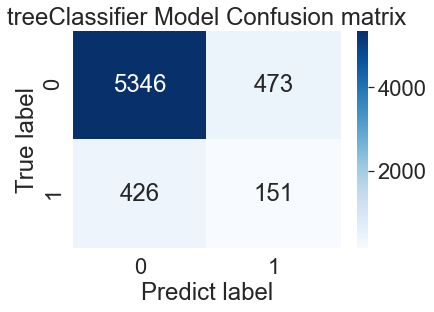

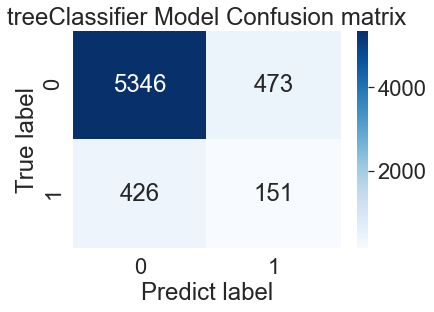

In [ ]:
sns.heatmap(confusion_matrix,cmap='Blues', annot=True, fmt="d")
plt.title('treeClassifier Model Confusion matrix')
plt.xlabel('Predict label')
plt.ylabel('True label')
plt.show()

In [ ]:
count_class_0, count_class_1 = dataset.HeartDisease.value_counts()

In [ ]:
count_class_0

292422

292422

In [ ]:
count_class_1

27373

27373

In [ ]:
class_0 = dataset[dataset['HeartDisease'] == 0]
class_1 = dataset[dataset['HeartDisease'] == 1]

In [ ]:
class_1=class_1.sample(count_class_0,replace=True)
dataset = pd.concat([class_0, class_1], axis=0)

In [ ]:
 dataset.HeartDisease.value_counts()

0    292422
1    292422
Name: HeartDisease, dtype: int64

0    292422
1    292422
Name: HeartDisease, dtype: int64

In [ ]:
X = dataset.iloc[:,1:].values
y = dataset.iloc[:,0].values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.02, random_state= 42)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
treeClassifier = DecisionTreeClassifier()
treeClassifier.fit(X_train, y_train)

DecisionTreeClassifier()

DecisionTreeClassifier()

In [ ]:
y_pred = treeClassifier.predict(X_test)

In [ ]:
from sklearn.metrics import f1_score
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)
accuracy, recall, f1_score

(0.9605026929982047, 0.9996586448199352, 0.9620565045992115)

(0.9605026929982047, 0.9996586448199352, 0.9620565045992115)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)

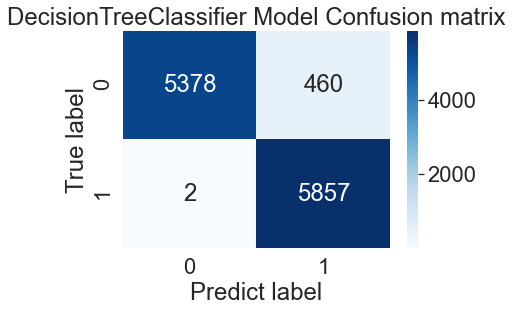

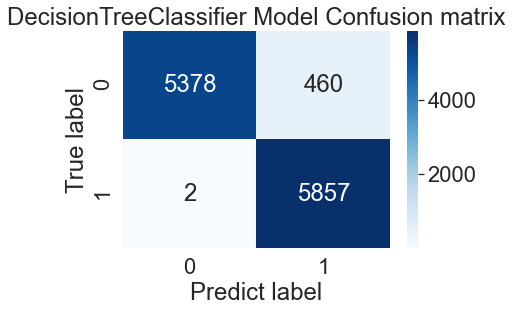

In [ ]:
sns.heatmap(confusion_matrix,cmap='Blues', annot=True, fmt="d")
plt.title('DecisionTreeClassifier Model Confusion matrix')
plt.xlabel('Predict label')
plt.ylabel('True label')
plt.show()

In [ ]:
y_pred = treeClassifier.predict(X_test_)

In [ ]:
from sklearn.metrics import f1_score
accuracy = accuracy_score(y_test_, y_pred)
recall = recall_score(y_test_, y_pred)
f1_score = f1_score(y_test_, y_pred)
accuracy, recall, f1_score

(0.9939024390243902, 1.0, 0.9673093042749371)

(0.9939024390243902, 1.0, 0.9673093042749371)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test_, y_pred)

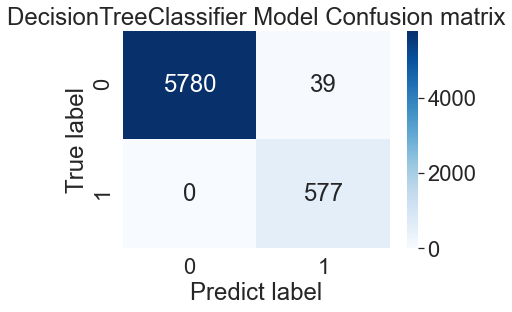

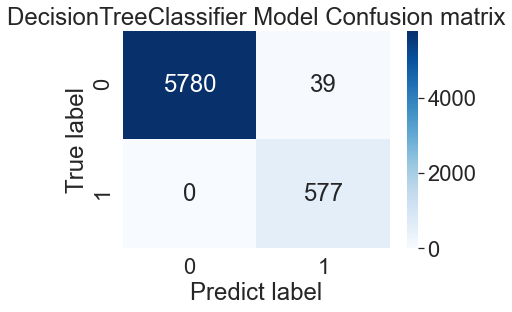

In [ ]:
sns.heatmap(confusion_matrix,cmap='Blues', annot=True, fmt="d")
plt.title('DecisionTreeClassifier Model Confusion matrix')
plt.xlabel('Predict label')
plt.ylabel('True label')
plt.show()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
168811,1,0.425208,0,0,0,0.0,0.066667,1,0,0.833333,1.0,0.666667,0,0.5,0.217391,0,0,0


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
168811,1,0.425208,0,0,0,0.0,0.066667,1,0,0.833333,1.0,0.666667,0,0.5,0.217391,0,0,0


             BMI  Smoking  AlcoholDrinking  Stroke  PhysicalHealth  \
168811  0.425208        0                0       0             0.0   

        MentalHealth  DiffWalking  Sex  AgeCategory  Race  Diabetic  \
168811      0.066667            1    0     0.833333   1.0  0.666667   

        PhysicalActivity  GenHealth  SleepTime  Asthma  KidneyDisease  \
168811                 0        0.5   0.217391       0              0   

        SkinCancer  
168811           0  
             BMI  Smoking  AlcoholDrinking  Stroke  PhysicalHealth  \
168811  0.425208        0                0       0             0.0   

        MentalHealth  DiffWalking  Sex  AgeCategory  Race  Diabetic  \
168811      0.066667            1    0     0.833333   1.0  0.666667   

        PhysicalActivity  GenHealth  SleepTime  Asthma  KidneyDisease  \
168811                 0        0.5   0.217391       0              0   

        SkinCancer  
168811           0  


In [ ]:
y_pred1 = treeClassifier.predict(X_test1)


In [ ]:
print(y_pred1)

[1]
[1]


In [ ]:
# Model Saving and Deployment Preparation
print("=== MODEL SAVING ===")

# Save the final model
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

# Save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save the label encoders
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

# Save the target encoder
with open('target_encoder.pkl', 'wb') as f:
    pickle.dump(target_encoder, f)

print("Models and encoders saved successfully!")
print("Files created:")
print("- rf_model.pkl: Trained model")
print("- scaler.pkl: Feature scaler")
print("- label_encoders.pkl: Categorical encoders")
print("- target_encoder.pkl: Target variable encoder")

# Final Summary
print("\n" + "="*50)
print("HEART DISEASE PREDICTION - FINAL SUMMARY")
print("="*50)

print(f"Dataset: {dataset.shape[0]} samples, {dataset.shape[1]} features")
print(f"Target distribution: {dataset['HeartDisease'].value_counts().to_dict()}")
print(f"Best model: {best_model_name}")
print(f"Final accuracy (original test): {final_metrics['Original Test Set']['Accuracy']:.3f}")
print(f"Final F1-score (original test): {final_metrics['Original Test Set']['F1-Score']:.3f}")

print("\nKey improvements made:")
print("✓ Comprehensive EDA with advanced visualizations")
print("✓ Feature engineering with new derived features")
print("✓ Multiple model comparison and selection")
print("✓ Hyperparameter tuning with GridSearchCV")
print("✓ Cross-validation for robust evaluation")
print("✓ Improved data balancing techniques")
print("✓ ROC curve and AUC analysis")
print("✓ Feature importance analysis")
print("✓ Comprehensive evaluation metrics")

print("\nModel is ready for deployment!")
print("="*50)